# 0.0 Imports

## 0.1 Imports

In [1]:
import pandas            as pd
import xgboost           as xgb
import random            as rds
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from scipy                 import stats as ss
from IPython.core.display  import HTML
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from tabulate              import tabulate

import datetime
import html
import inflection
import math
import pickle
import warnings
warnings.filterwarnings('ignore')

## 0.2 Helper Functions

In [2]:
#função para deixar os graficos melhores visualmente
%matplotlib inline
%pylab inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v

In [4]:
def mean_absolute_percentage_error(y,yhat):
    return np.mean( np.abs( ( y - yhat ) / y ) )    

In [5]:
def mean_percentage_error(y,yhat):
    return np.mean( ( y - yhat ) / y )    

In [6]:
def ml_error( model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

In [7]:
def cross_validation ( x_training,kfold,model_name,model,verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed(range (1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #Data inicial e final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)
        #print('Data Inicial:  {}'.format(validation_start_date))
        #print('Data Final:  {}'.format(validation_end_date))

        #filtrando dados de treinamento
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date']<=validation_end_date)]

        #Tirando as variaveis tempo e vendas para previsão
        #treino
        xtraining=training.drop(['date','sales'],axis=1)
        ytraining=training['sales']

        #validacao
        xvalidation=validation.drop(['date','sales'],axis=1)
        yvalidation=validation['sales']

        ##modelo
        m=model.fit(xtraining,ytraining)
        # predicao
        yhat= m.predict(xvalidation)
        # performance
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        #Salvando resultados nas listas
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        #print (lr_result)

    return pd.DataFrame( 
        {
         'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str)+ '+/-' + np.round( np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str)+ '+/-' + np.round( np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)+ '+/-' + np.round( np.std(rmse_list),2).astype(str)
        }, index=[0])

## 0.3. Loading data

In [8]:
df_sales_raw = pd.read_csv ('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw,df_store_raw, how="left", on="Store")

In [9]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Data Description

In [10]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [11]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment',       'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 Data Dimension

In [14]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [15]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [17]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill NA

In [18]:
df1['competition_distance'].max()

75860.0

Competition Distance is the distance in meter between the store and his closely competitor. I presume that field is missing, because this store dont have competitor or he is so far that is not necessary classifing him as a competitor. The max distance on the dataset is 75860, so i'll set the missing values with 200000

In [13]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

**competition open since month = Month that competitor openning**

**competition open since year = Year that competitor openning**

I presume that fields is missing because he don't have competitor or the competitor was open before this store open. I'll will set missing values with month and year of sale.

In [14]:
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

**promo2_since_week - Month that this store extended promo period**

**promo2_since_year - Year that this store extended promo period**

I presume that fields is missing because its never extended promo period, but how i have the field **promo** that identifiy if the sale was in promo week, i'll set missing values with month and year of sale.

In [15]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)


df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64

**promo_interval - Months that extension promo was active**
I presume that field is missing because its never extended promo period, but how i have the field promo that identifiy if the sale was in promo week, i'll set missing values with month of sale.

In [16]:
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Set',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0,inplace=True)

df1['month_map']=df1['date'].dt.month.map(month_map)

df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [23]:
df1.sample(10).T

,318819,730390,879050,740545,212265,146441,27613,560461,223090,574543
store,200,851,101,971,416,377,854,402,91,1104
day_of_week,6,7,6,5,4,7,2,5,1,7
date,2014-10-04 00:00:00,2013-09-15 00:00:00,2013-05-04 00:00:00,2013-09-06 00:00:00,2015-01-22 00:00:00,2015-03-22 00:00:00,2015-07-07 00:00:00,2014-02-14 00:00:00,2015-01-12 00:00:00,2014-02-02 00:00:00
sales,7548,0,6199,5831,8475,0,4433,4751,6351,0
customers,979,0,764,826,1240,0,481,580,626,0
open,1,0,1,1,1,0,1,1,1,0
promo,0,0,0,0,0,0,0,0,1,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0,0,0
store_type,a,d,d,c,a,a,c,c,c,d


In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [26]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Statistical Description

In [18]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','int32','float64','datetime64[ns]'])

### 1.7.1 Numericals Attributes

In [30]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns= ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

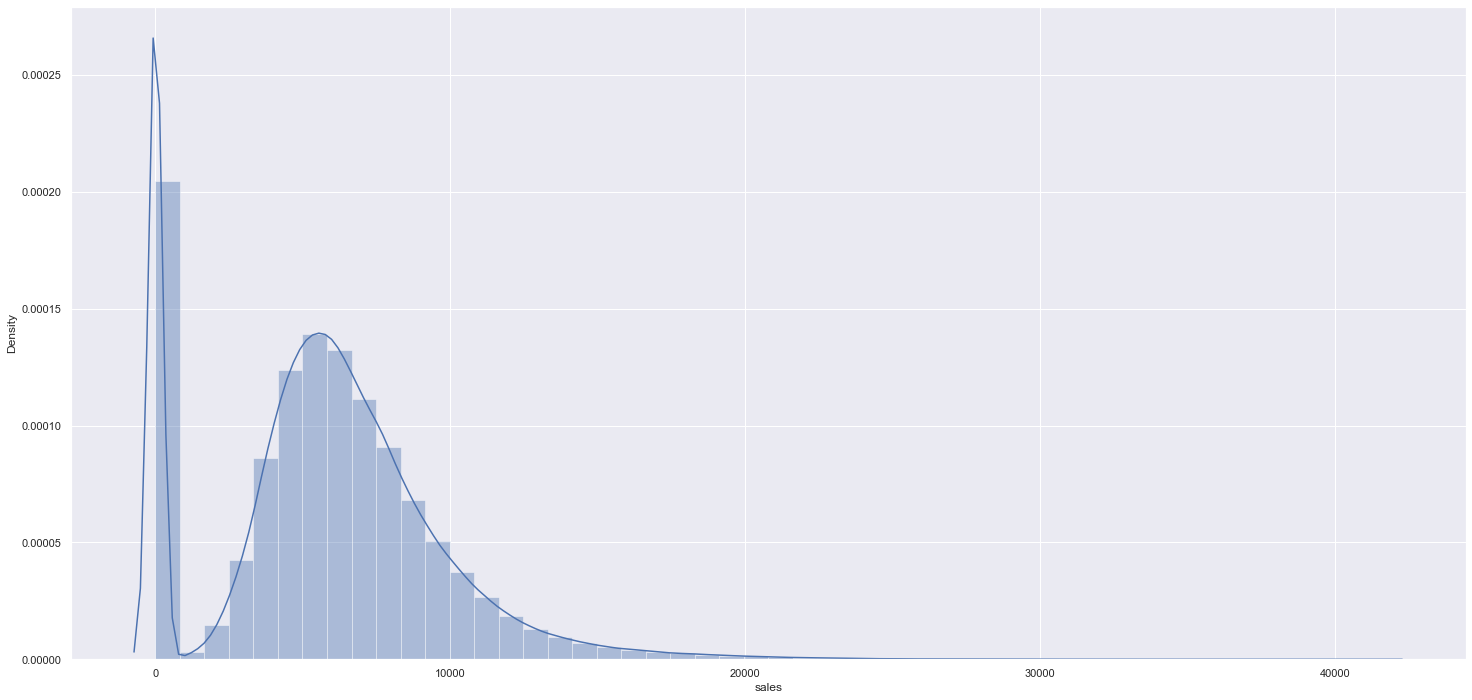

In [28]:
sns.distplot(df1['sales'])

### 1.7.2 Categorial Attributes

In [31]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

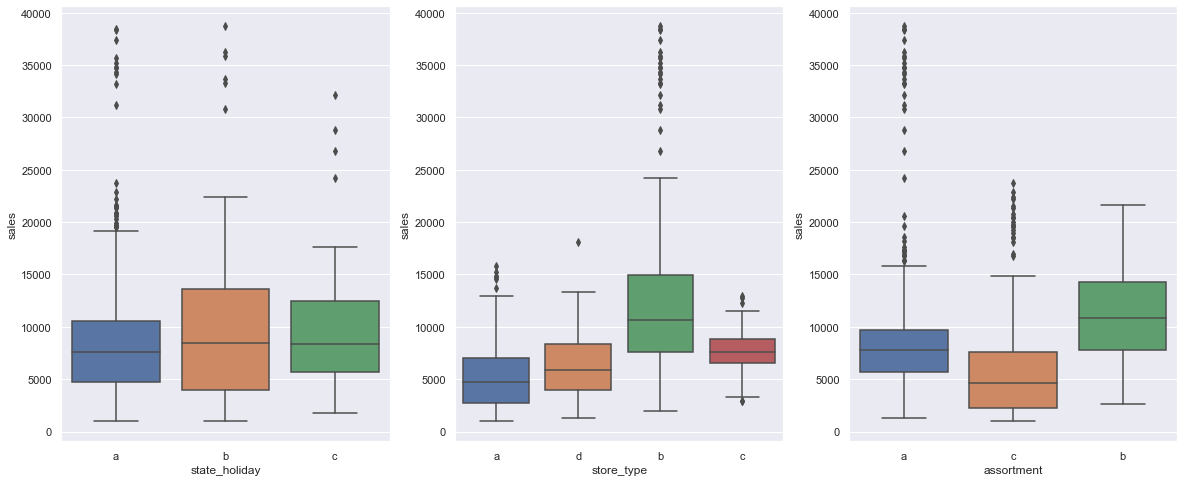

In [37]:
aux1= df1[(df1['state_holiday']!= '0' ) & (df1['sales']> 0 )]
plt.figure( figsize= (20,8))
plt.subplot(1,3,1)

sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

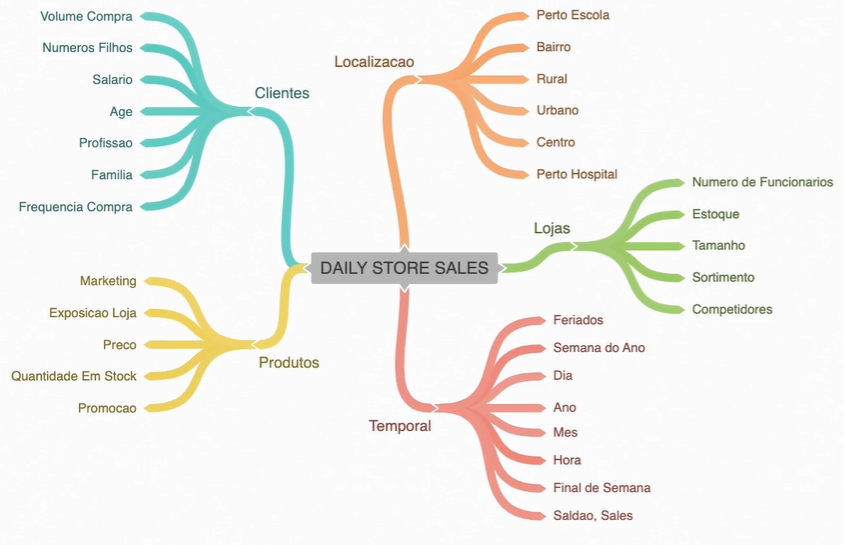

In [33]:
Image('img/mindMapHypoteses.png')

In [19]:
df2 = df1.copy()

## 2.1 Hypotheses Creation

### 2.1.1 Shop Hypotheses

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vendas mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender mais 

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2 Product Hypotheses

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoem mais os produtos na vitrine deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Time Hypotheses

**1.** Lojas abertas durante o feriado de natal deveria vender mais

**2.** Lojas deveriam vender mais ao longos dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas fdeveriam vender menos durante os feriados escolares

## 2.2 Final List Hypotheses


**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender mais 

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de natal deveria vender mais

**8.** Lojas deveriam vender mais ao longos dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas fdeveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [20]:
#year
df2['year']=df2['date'].dt.year

#month
df2['month']=df2['date'].dt.month

#day
df2['day']=df2['date'].dt.day

#week of year
df2['week_of_year']=df2['date'].dt.weekofyear

#year week
df2['year_week']=df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime ( year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days ).astype (int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' +df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime ( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype ( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

# state holliday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holliday' if x =='a' else 'easter_holliday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [40]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Data Filtering

In [21]:
df3 = df2.copy()

In [43]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,7,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-02-09,24
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,7,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-02-09,24
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,7,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-02-09,24


## 3.1 Filtragem das linhas

I'll exclude data when the store was closed, so have no sales.

In [22]:
df3 = df3[ ( df3['sales'] >0 ) & ( df3['open'] !=0 ) ]

## 3.2 Seleção de colunas

**customers** - I don't have the information how many customers will be on the store in the next 6 weeks, so this field its not necessary.
**open** - In above step i applied a filter to exclude all closed days, so this field its not necessary.
**promo_interval e month_map**  from this field i created new fields, so this fields its not necessary.

In [23]:
cols_drop=['customers', 'open', 'promo_interval' , 'month_map']
df3 = df3.drop(cols_drop,axis=1)

In [46]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In [24]:
df4 = df3.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Target Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

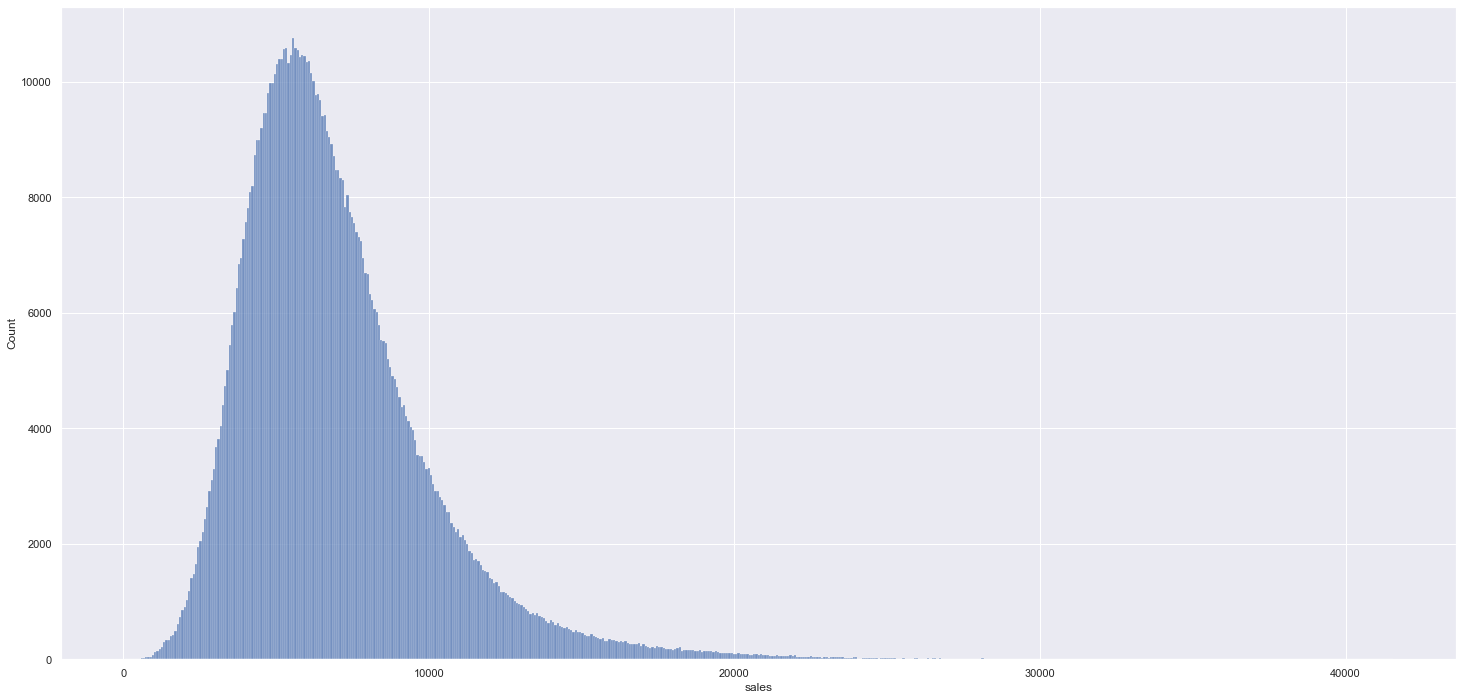

In [48]:
sns.histplot(df4['sales'])

### 4.1.2 - Numerical Variables

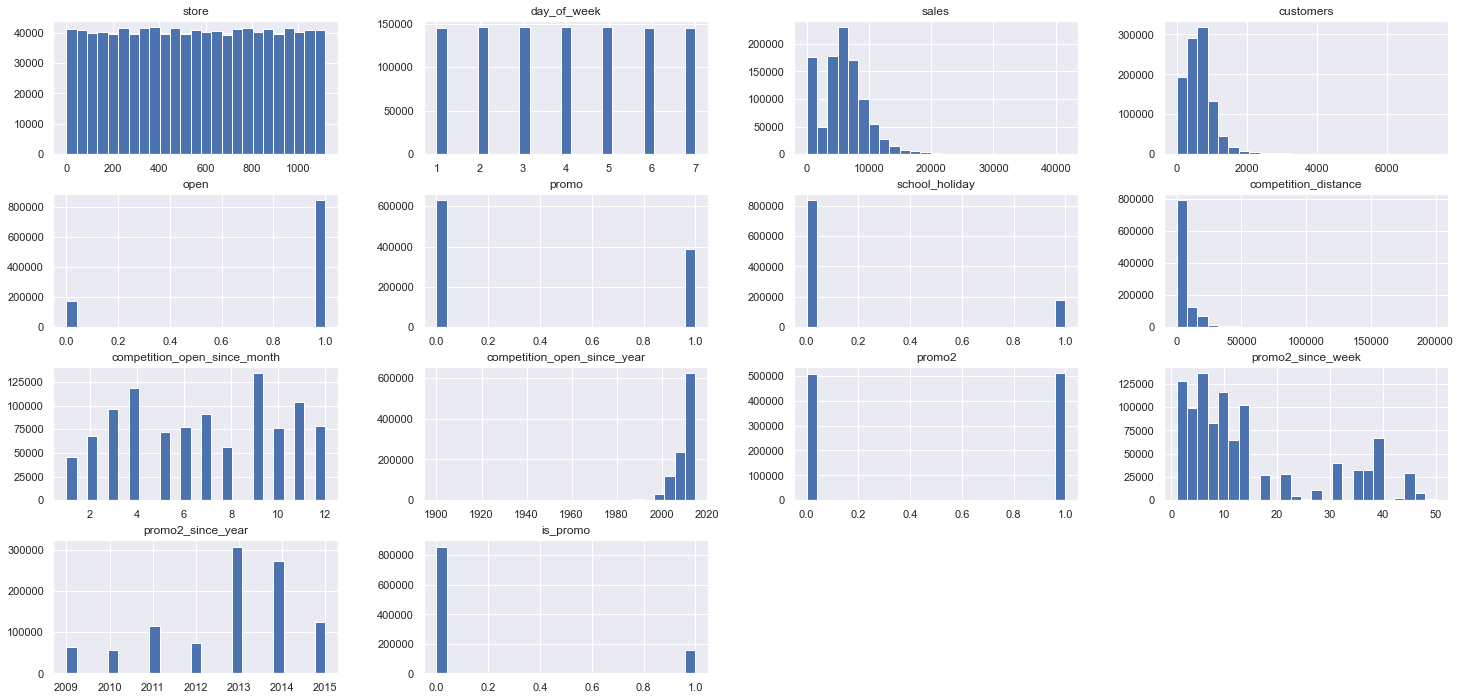

In [49]:
num_attributes.hist(bins=25);

### 4.1.3 - Categorical Variables

In [50]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


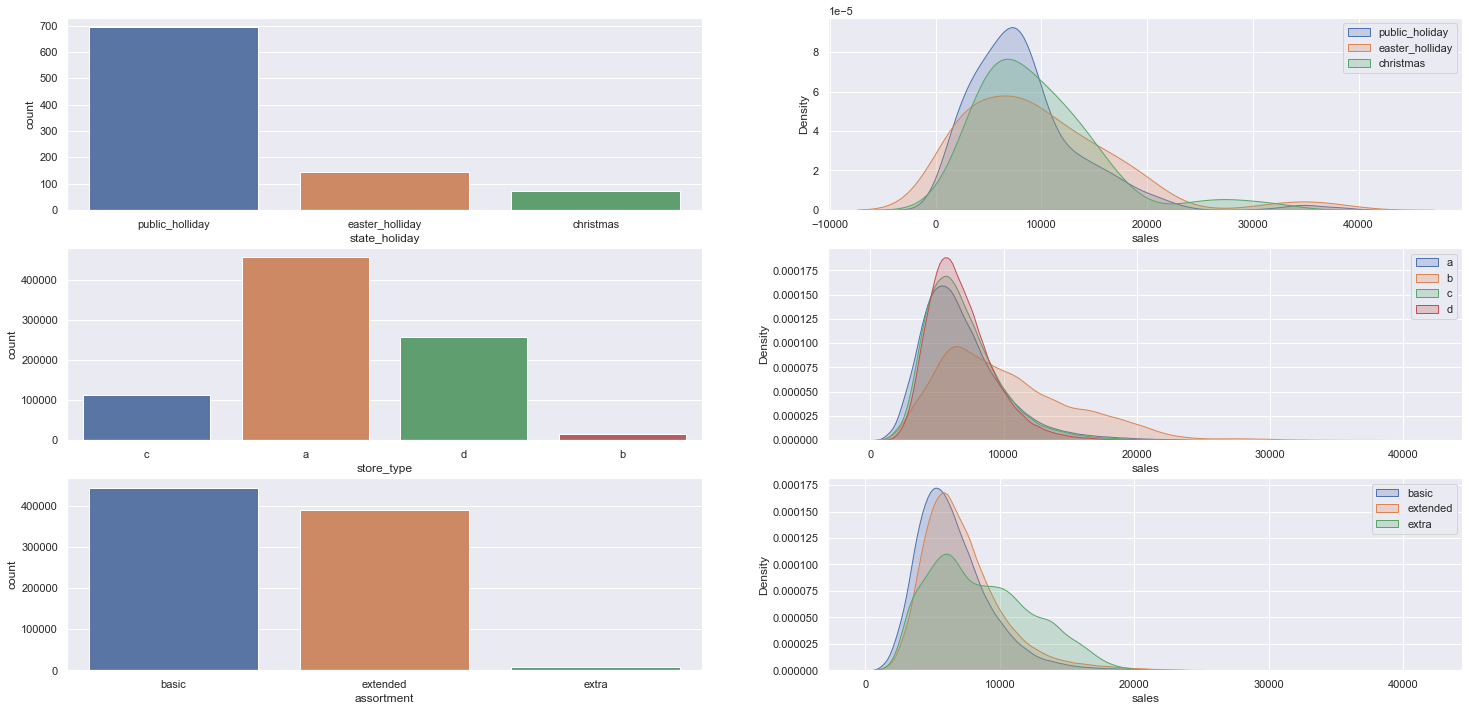

In [51]:
#state_holiday
plt.subplot(3,2,1)
hollidays = df4[df4['state_holiday']!='regular_day']
sns.countplot(x='state_holiday',data=hollidays)

plt.subplot(3,2,2)
sns.kdeplot (df4[df4['state_holiday'] == 'public_holliday']['sales'],label ='public_holiday',shade=True,legend=True)
sns.kdeplot (df4[df4['state_holiday'] == 'easter_holliday']['sales'],label ='easter_holliday',shade=True,legend=True)
sns.kdeplot (df4[df4['state_holiday'] == 'christmas']['sales'],label ='christmas',shade=True,legend=True)
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(x='store_type',data=df4)

plt.subplot(3,2,4)
sns.kdeplot (df4[df4['store_type'] == 'a']['sales'],label ='a',shade=True,legend=True)
sns.kdeplot (df4[df4['store_type'] == 'b']['sales'],label ='b',shade=True,legend=True)
sns.kdeplot (df4[df4['store_type'] == 'c']['sales'],label ='c',shade=True,legend=True)
sns.kdeplot (df4[df4['store_type'] == 'd']['sales'],label ='d',shade=True,legend=True)
plt.legend()

#assortment
plt.subplot(3,2,5)
sns.countplot(x='assortment',data=df4)

plt.subplot(3,2,6)
sns.kdeplot (df4[df4['assortment'] == 'basic']['sales'],label ='basic',shade=True,legend=True)
sns.kdeplot (df4[df4['assortment'] == 'extended']['sales'],label ='extended',shade=True,legend=True)
sns.kdeplot (df4[df4['assortment'] == 'extra']['sales'],label ='extra',shade=True,legend=True)
plt.legend()

## 4.2- Bivariate Analysis

### **H1.** Store with biggest assortment, should be more sales
**FALSE** Store with biggest assortment have less sales

<AxesSubplot:xlabel='assortment', ylabel='sales'>

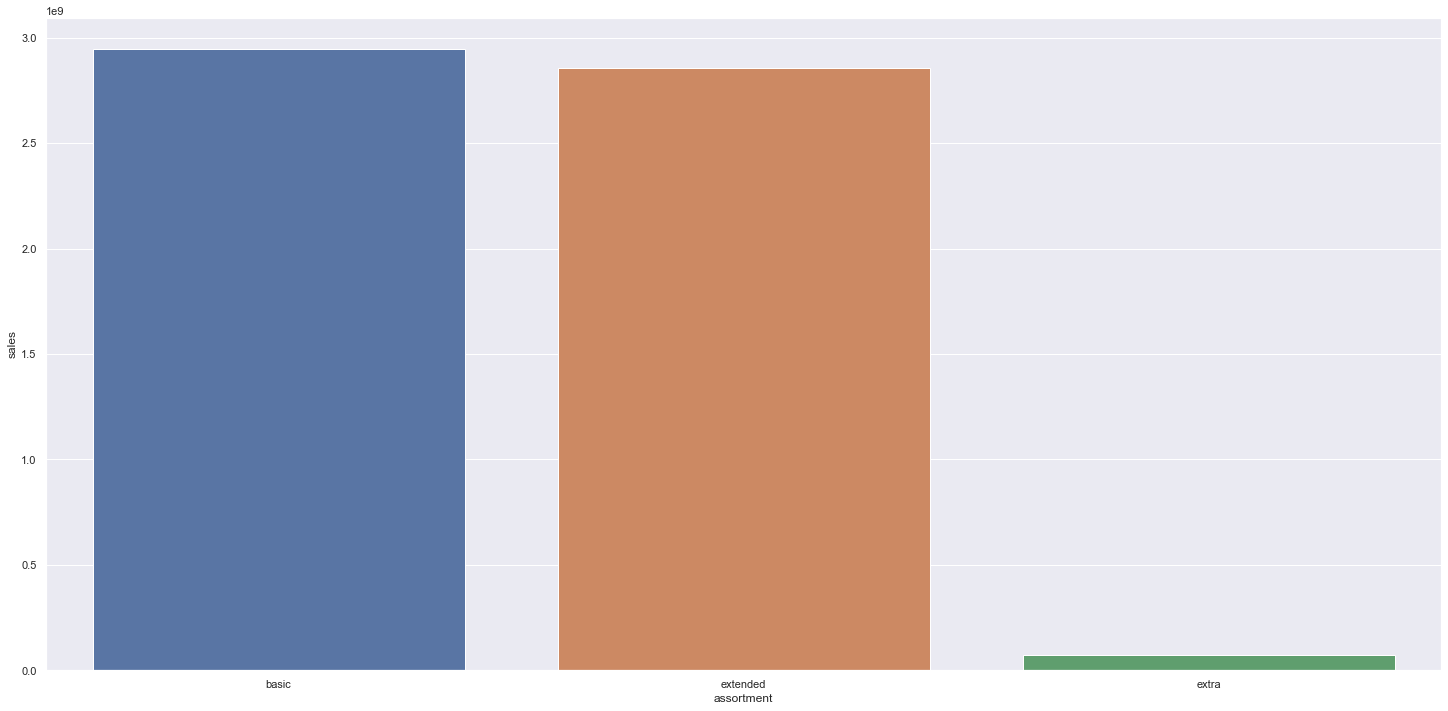

In [52]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot (x='assortment',y='sales', data=aux1)

<AxesSubplot:xlabel='year_week'>

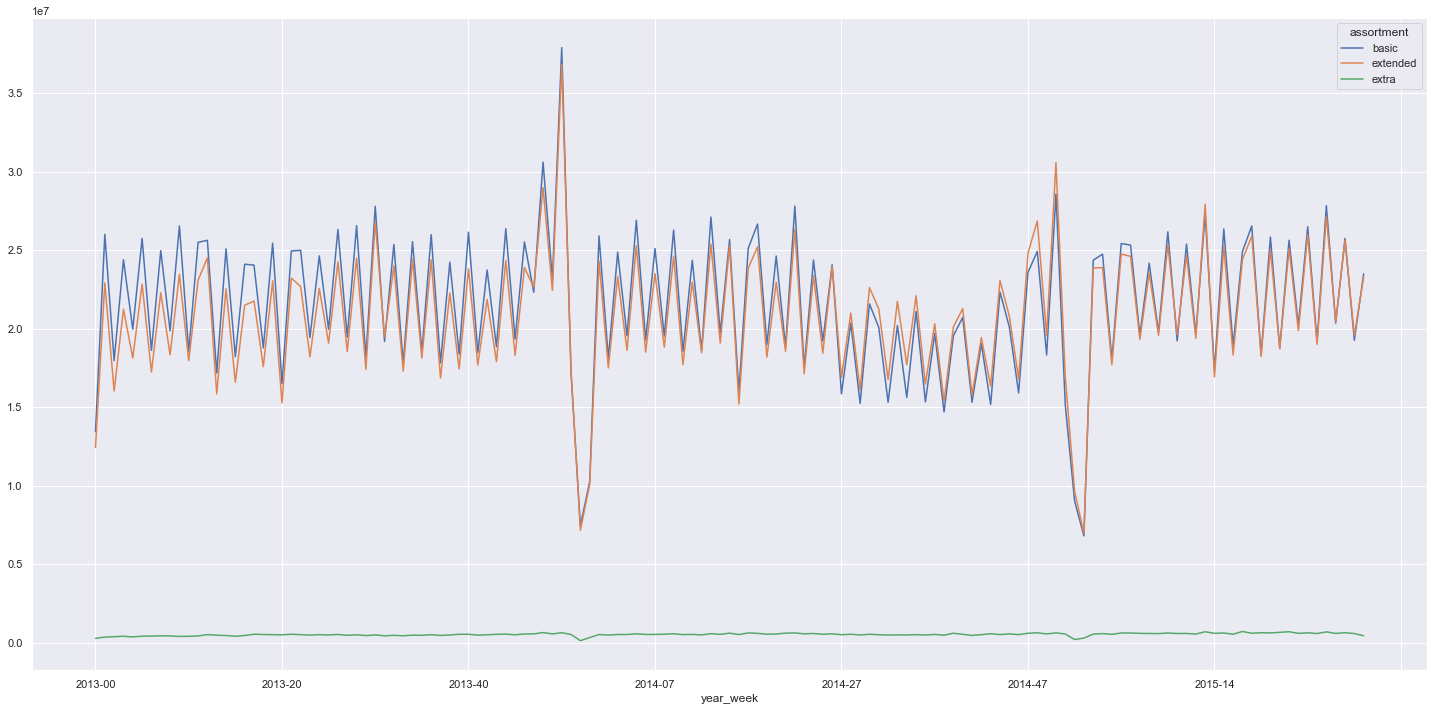

In [53]:
aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

<AxesSubplot:xlabel='year_week'>

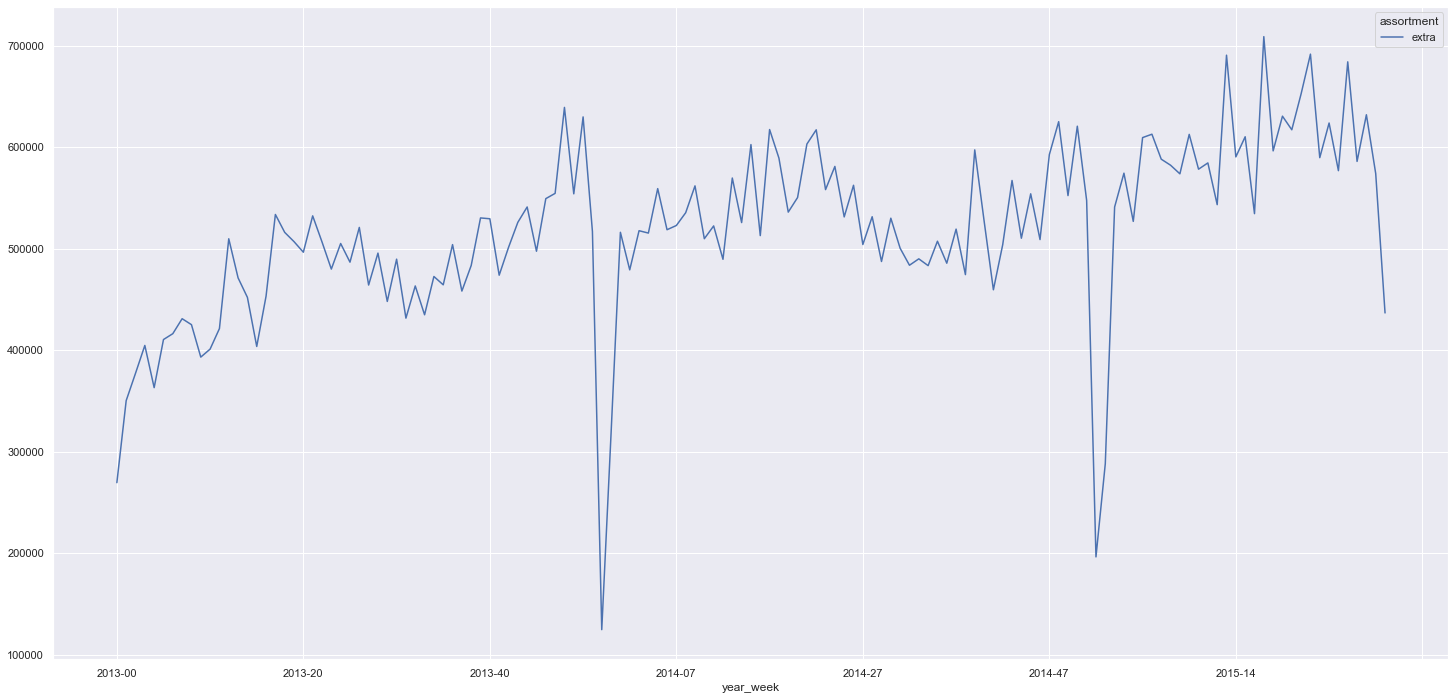

In [54]:
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()


 ### **H2.** Store with closely competitor should be less sales
**FALSE** Store with closely competitor, have more sales

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

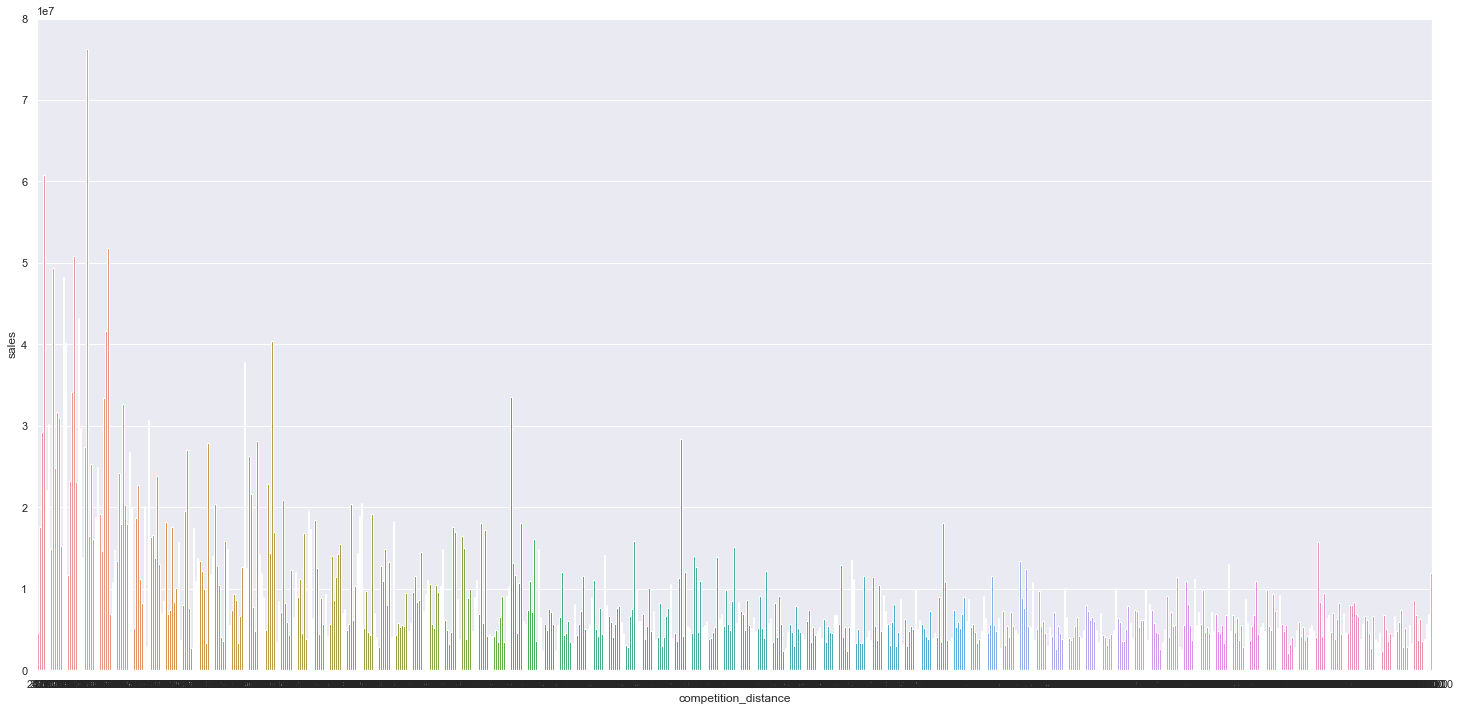

In [55]:
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot (x='competition_distance',y='sales', data=aux1)

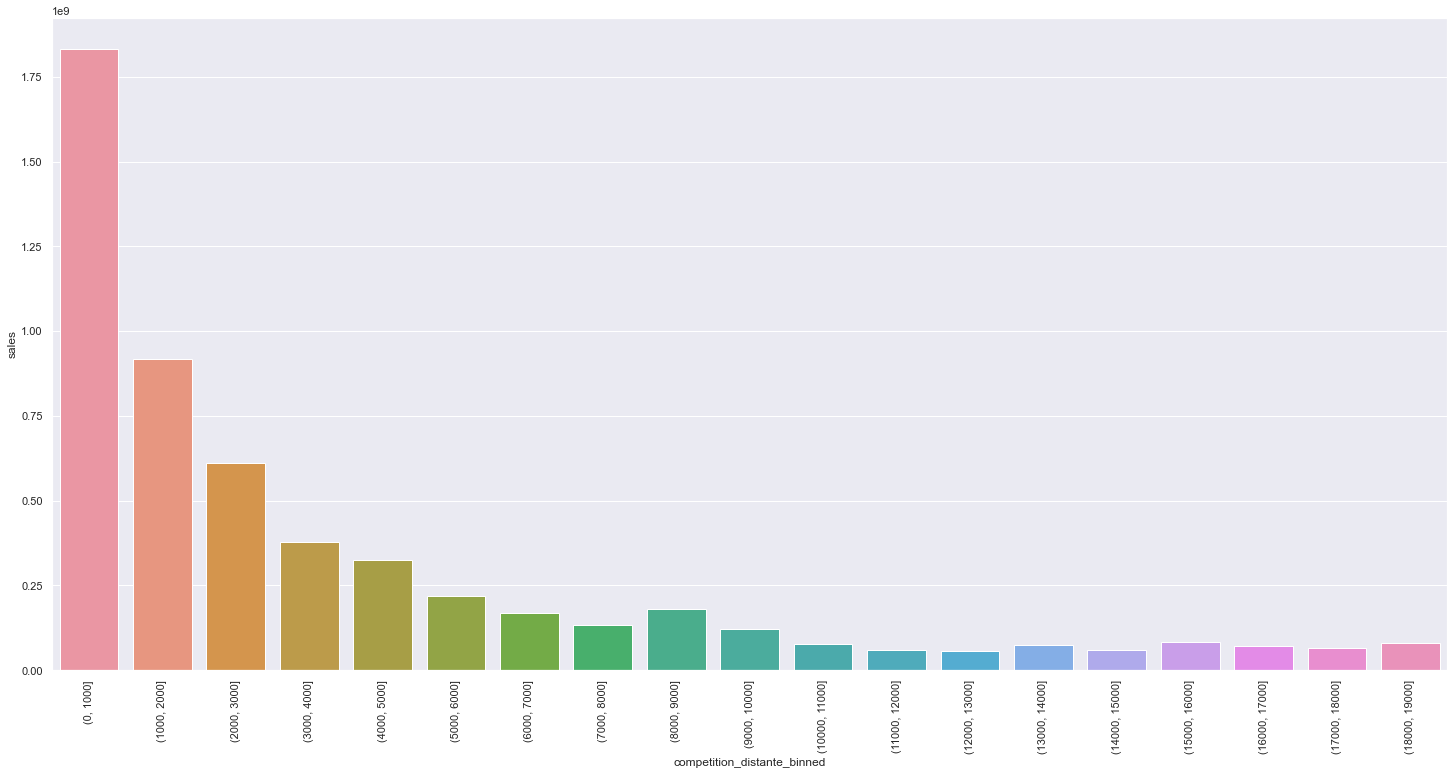

In [56]:
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competition_distante_binned']=pd.cut(aux1['competition_distance'],bins=bins)

aux2 = aux1[['competition_distante_binned','sales']].groupby( 'competition_distante_binned' ).sum().reset_index()
sns.barplot (x='competition_distante_binned',y='sales', data=aux2)

plt.xticks(rotation=90);

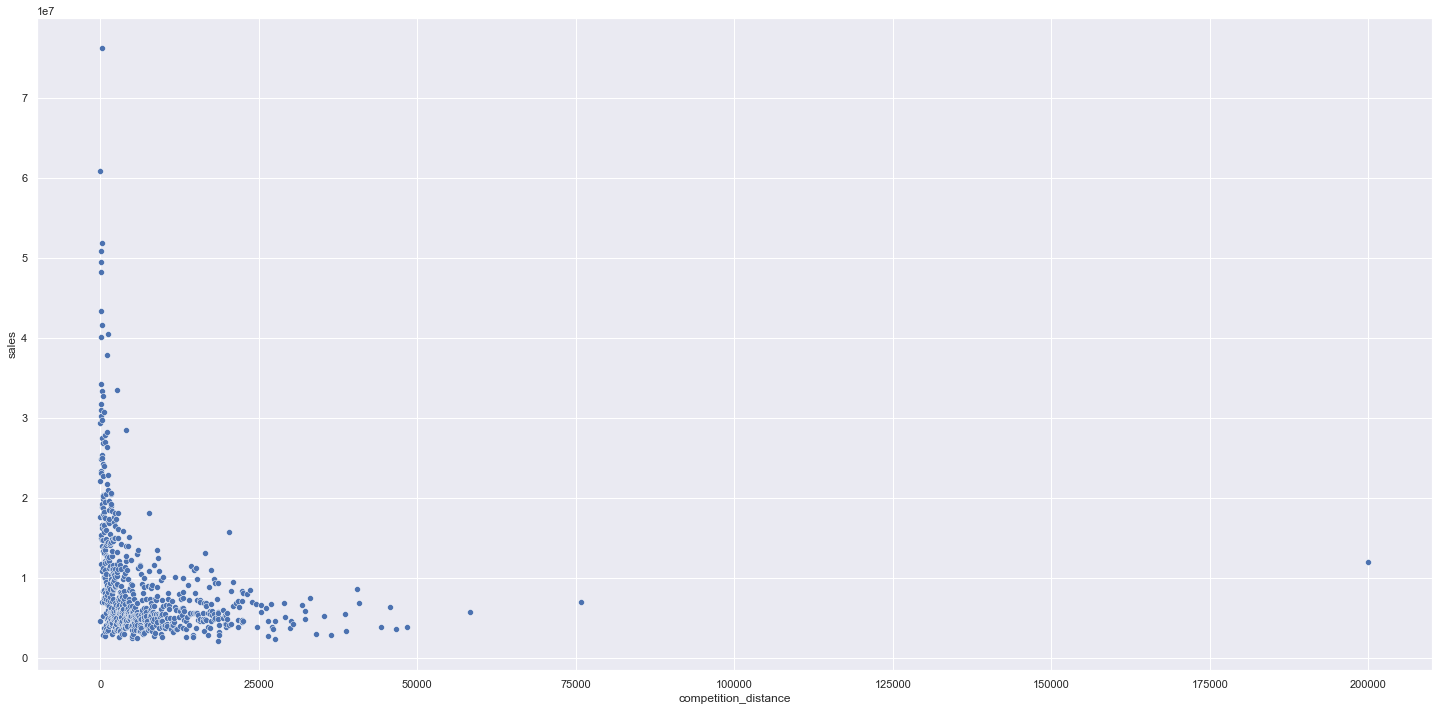

In [57]:
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( x='competition_distance',y='sales',data=aux1);

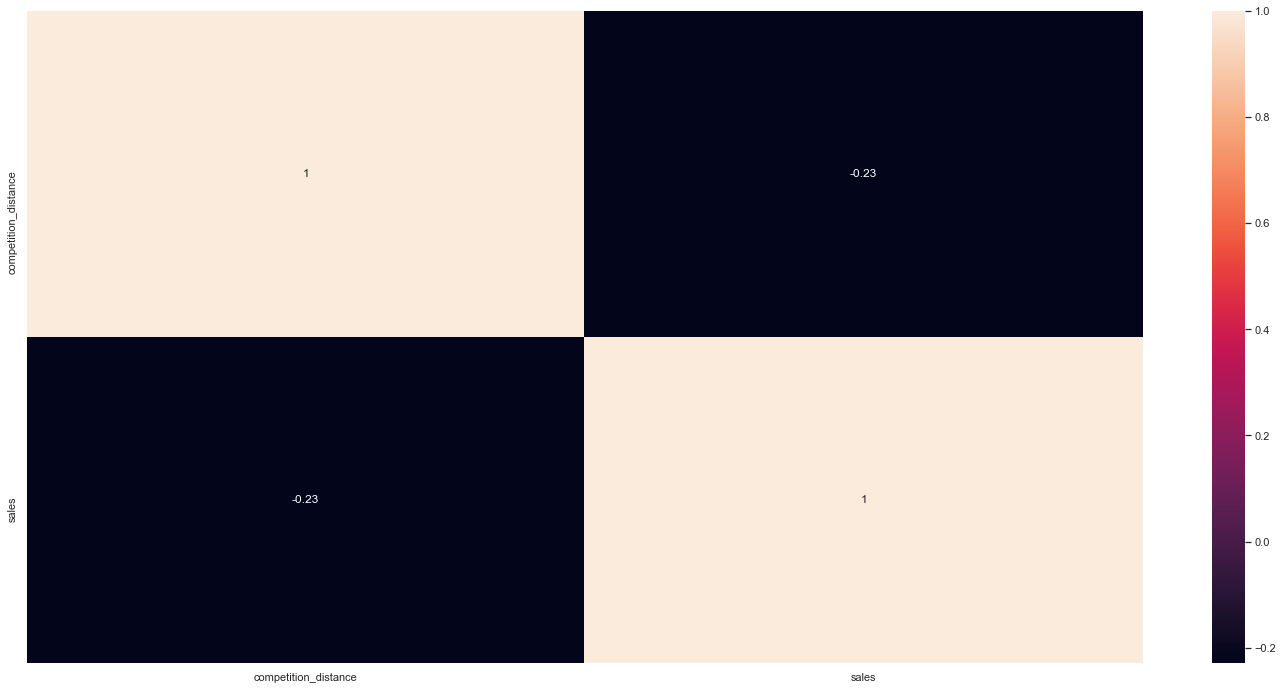

In [58]:
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### **H3.** Store with competitor for longer should be more sales
**FALSE** Store with competitor for longer have less sales

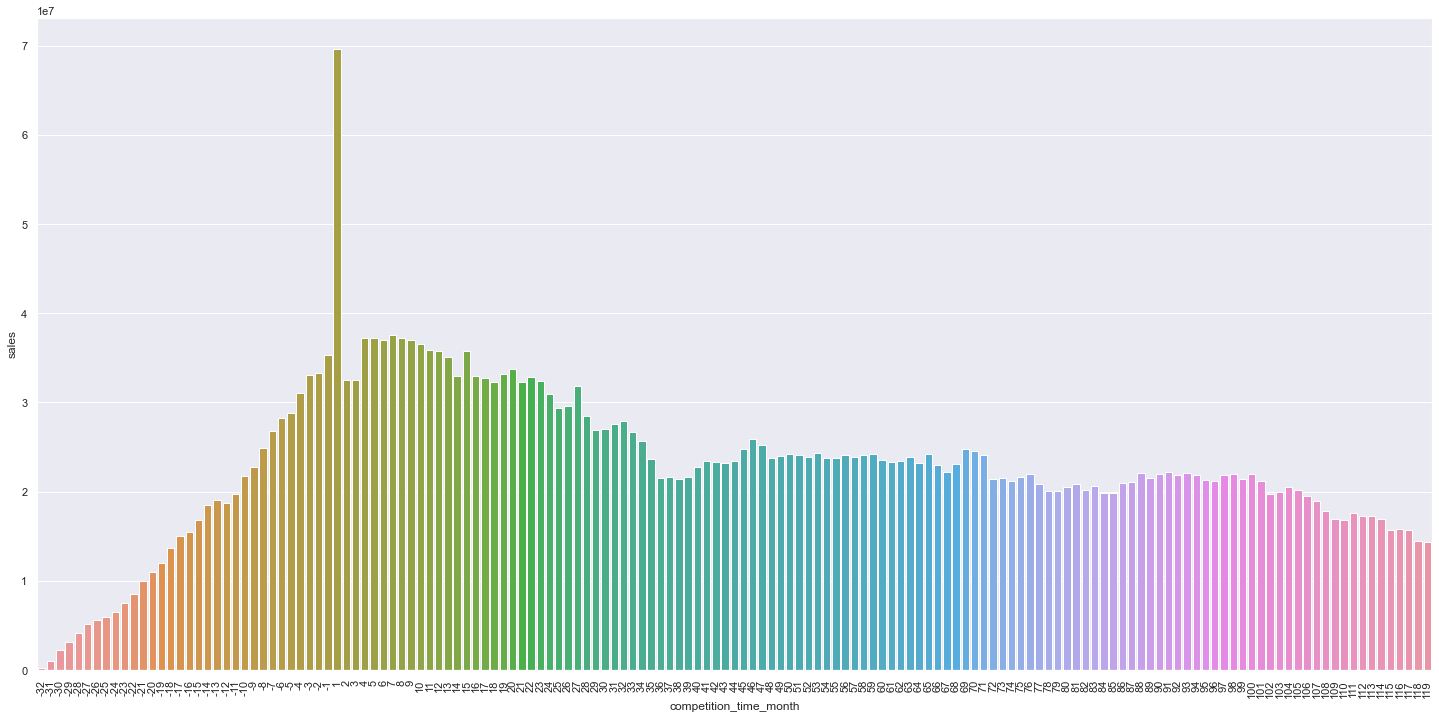

In [59]:
aux1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month']< 120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks( rotation=90 );

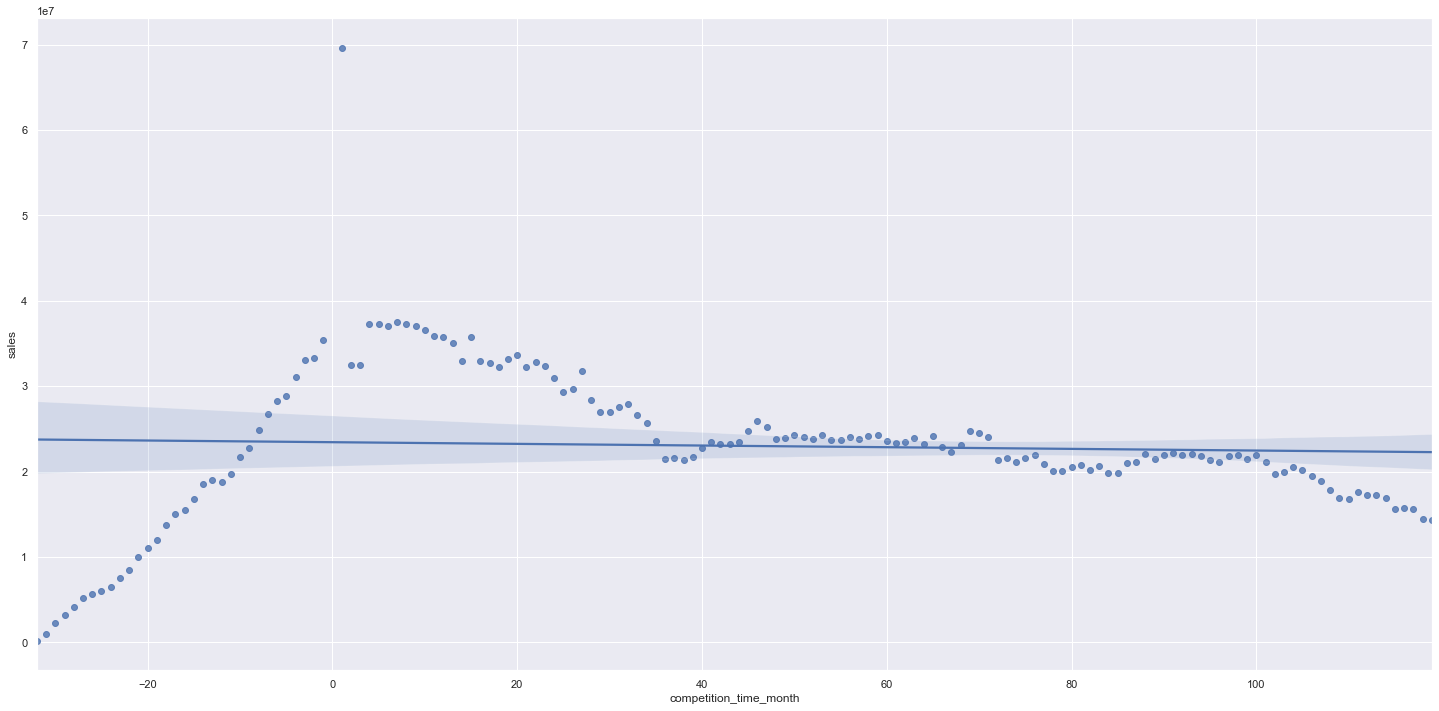

In [60]:
sns.regplot(x='competition_time_month',y='sales',data=aux2);

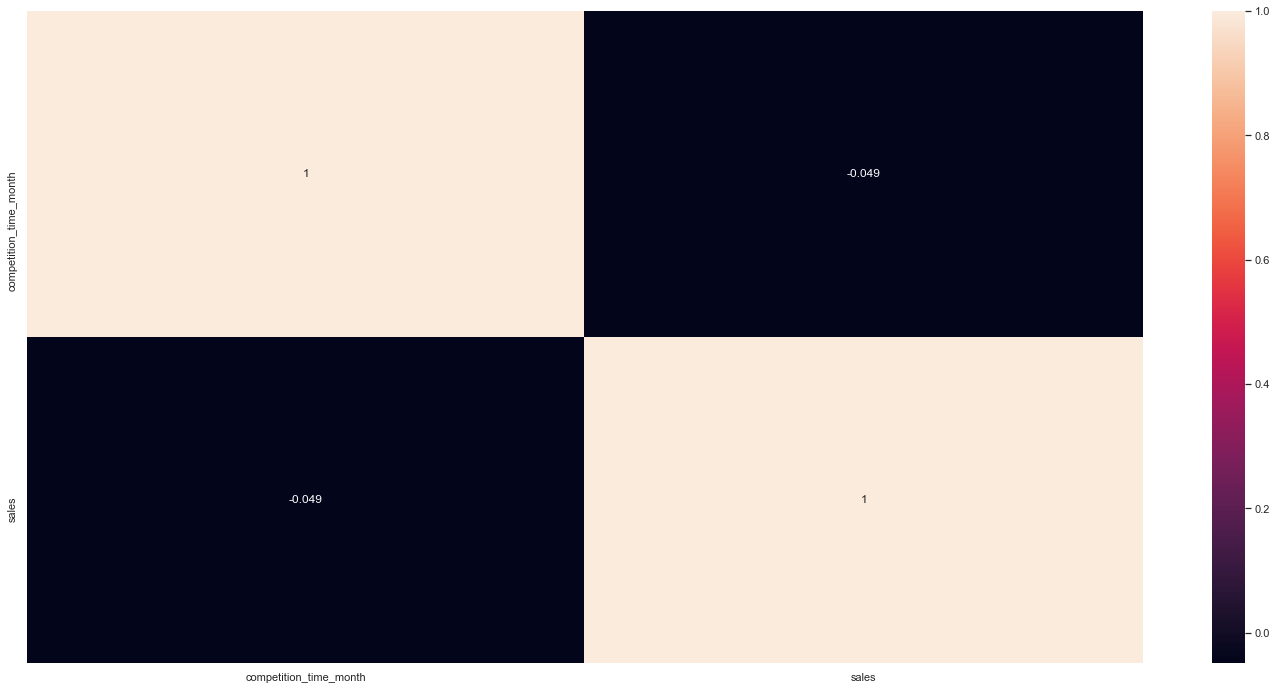

In [61]:
sns.heatmap(aux2.corr(method='pearson'),annot=True);

### **H4.** Stores with active promotions for longer should sell more
**FALSE** Stores with active promotions for longer have less sales after a period of promo

<AxesSubplot:>

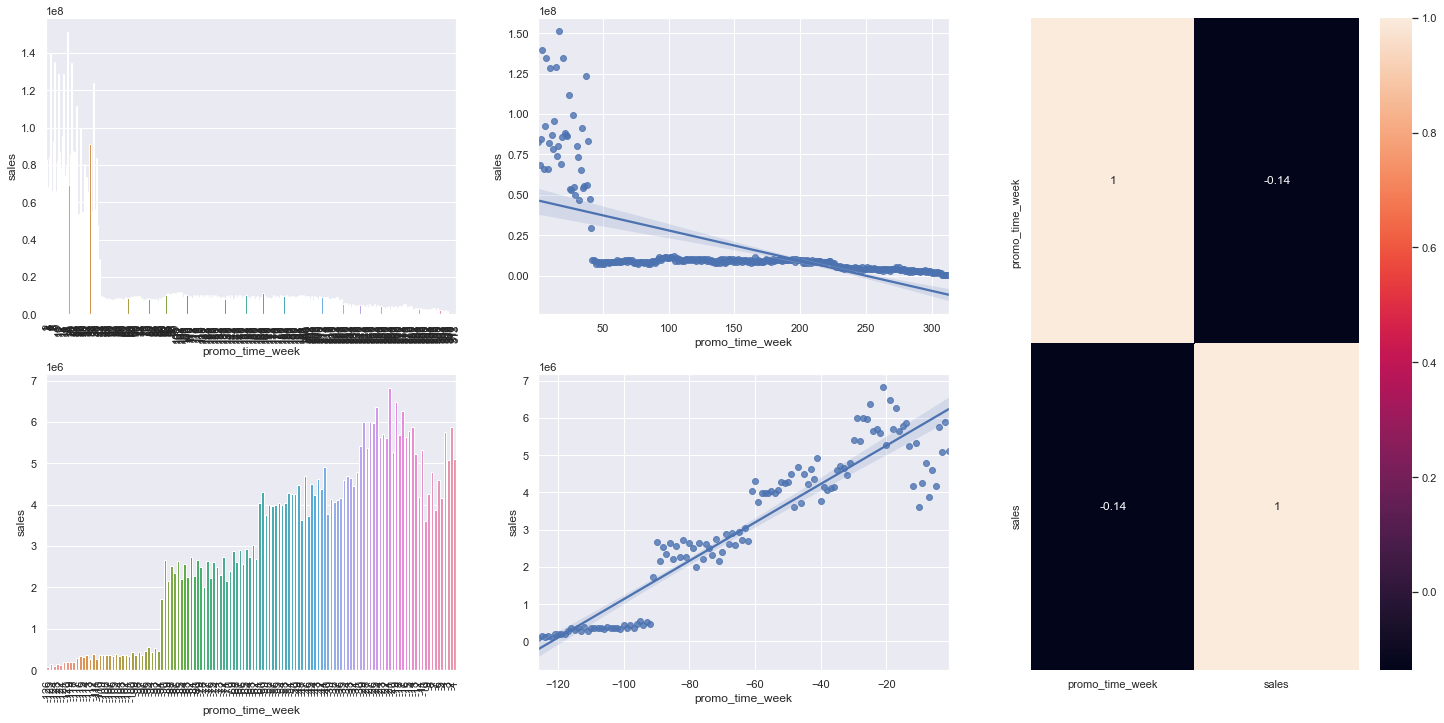

In [62]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] #promocao extentida
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks( rotation=90 );

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] #promocao regular
sns.barplot(x='promo_time_week',y='sales',data=aux3)
plt.xticks( rotation=90 );

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>**H5.** Store with more day in promo should sell more</s>

### **H6.** Store with sequential promos should sell more
**FALSE** Store with sequential promos ha ve less sales

In [63]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


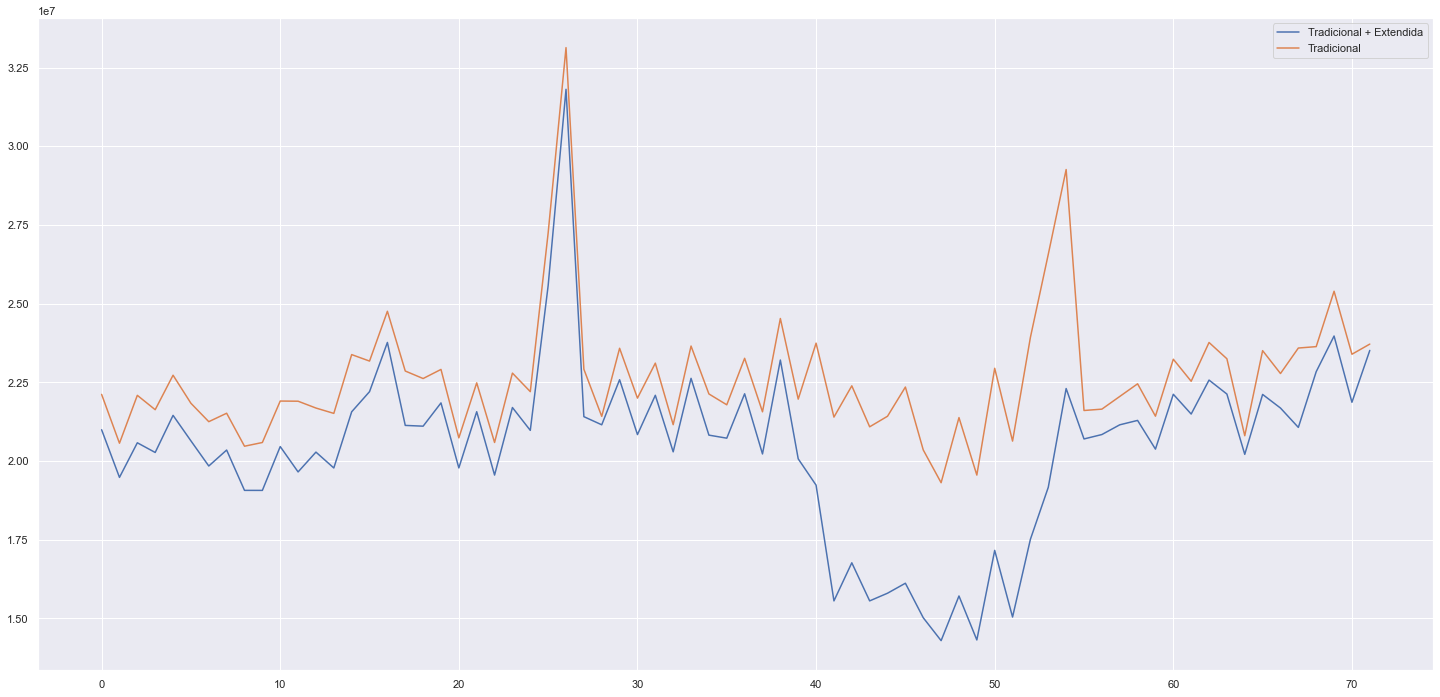

In [64]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional + Extendida','Tradicional'])

### **H7**. Store open in christmas holliday should sell more
**FALSE** Store open in christmas holliday have less sells

<AxesSubplot:xlabel='year', ylabel='sales'>

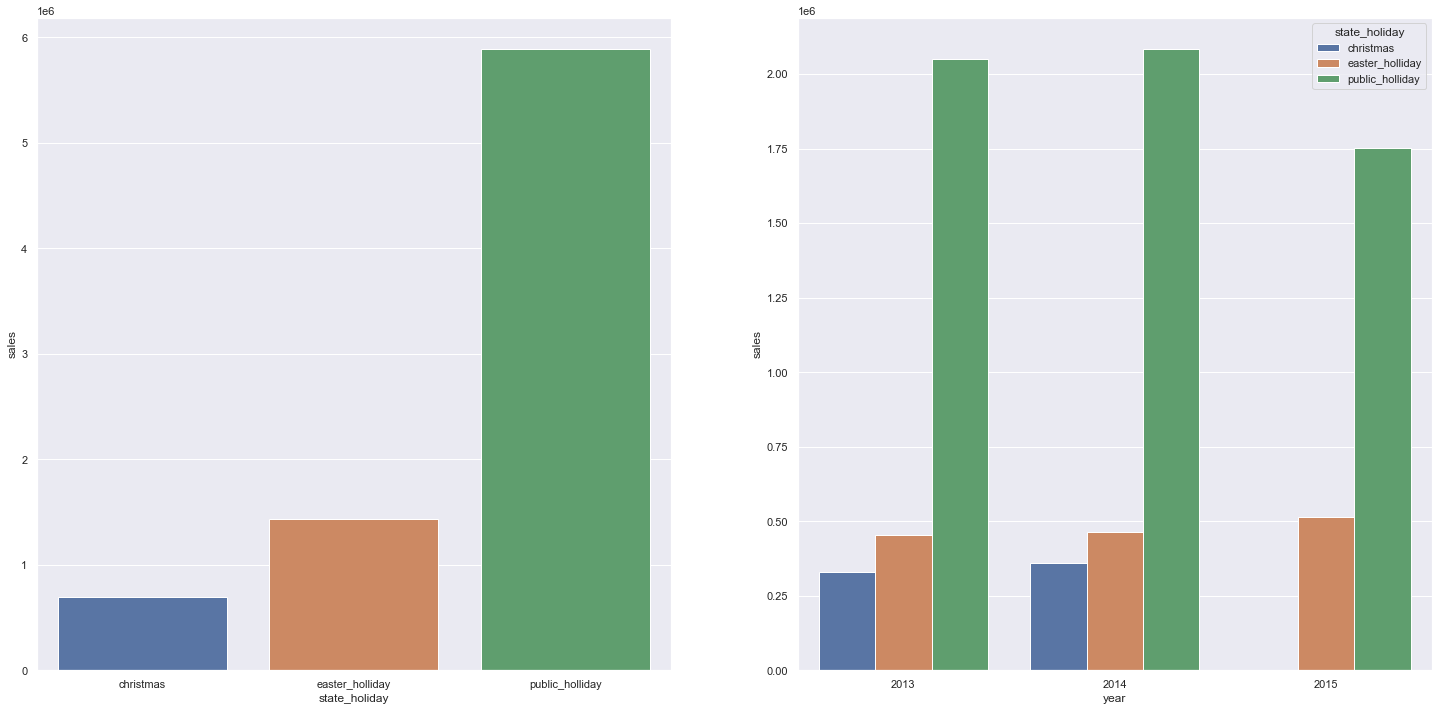

In [66]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday']!= 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['state_holiday','sales','year']].groupby(['state_holiday','year']).sum().reset_index()
sns.barplot(x='year',y='sales',data=aux2,hue='state_holiday')

### H8. Stores should sell more over the years
**FALSE** Stores sell LESS over the years

<AxesSubplot:>

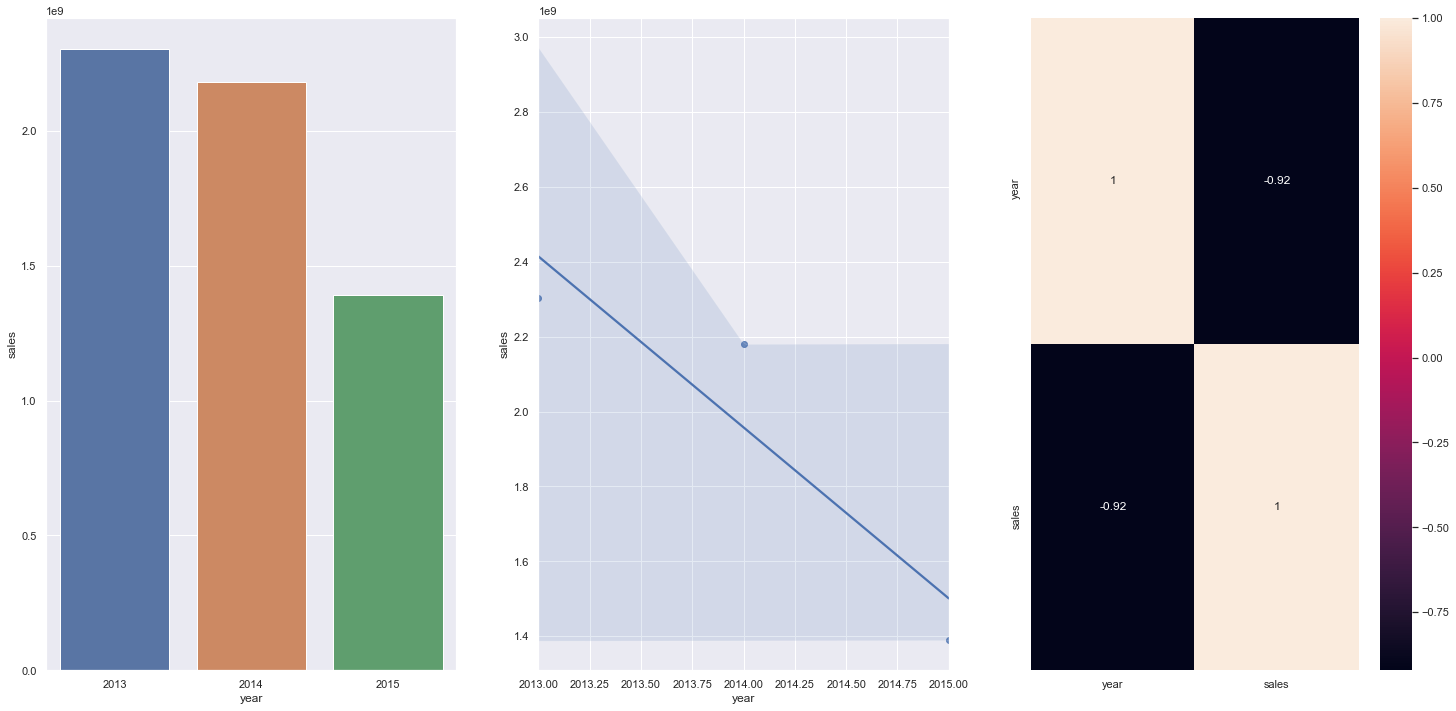

In [67]:
plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H9. Stores should sell more in the second half of the year
**FALSE** Stores sell LESS in the second half of the year 

<AxesSubplot:>

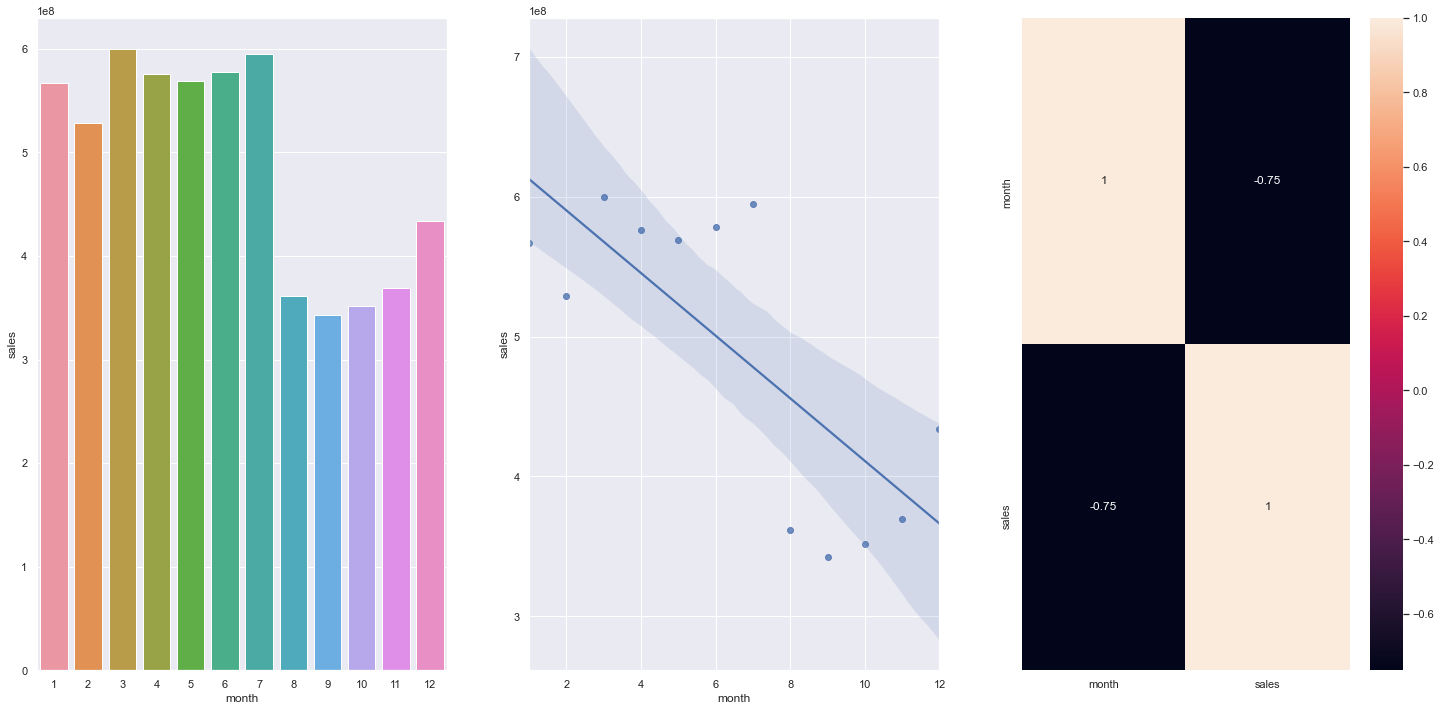

In [63]:
plt.subplot(1,3,1)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=aux1)

#Verificar tendencia
plt.subplot(1,3,2)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.regplot(x='month',y='sales',data=aux1)

#Correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H10. Stores should sell more after the 10th of each month
** TRUE ** Stores sell MORE after the 10th of each month

<AxesSubplot:xlabel='before_after', ylabel='sales'>

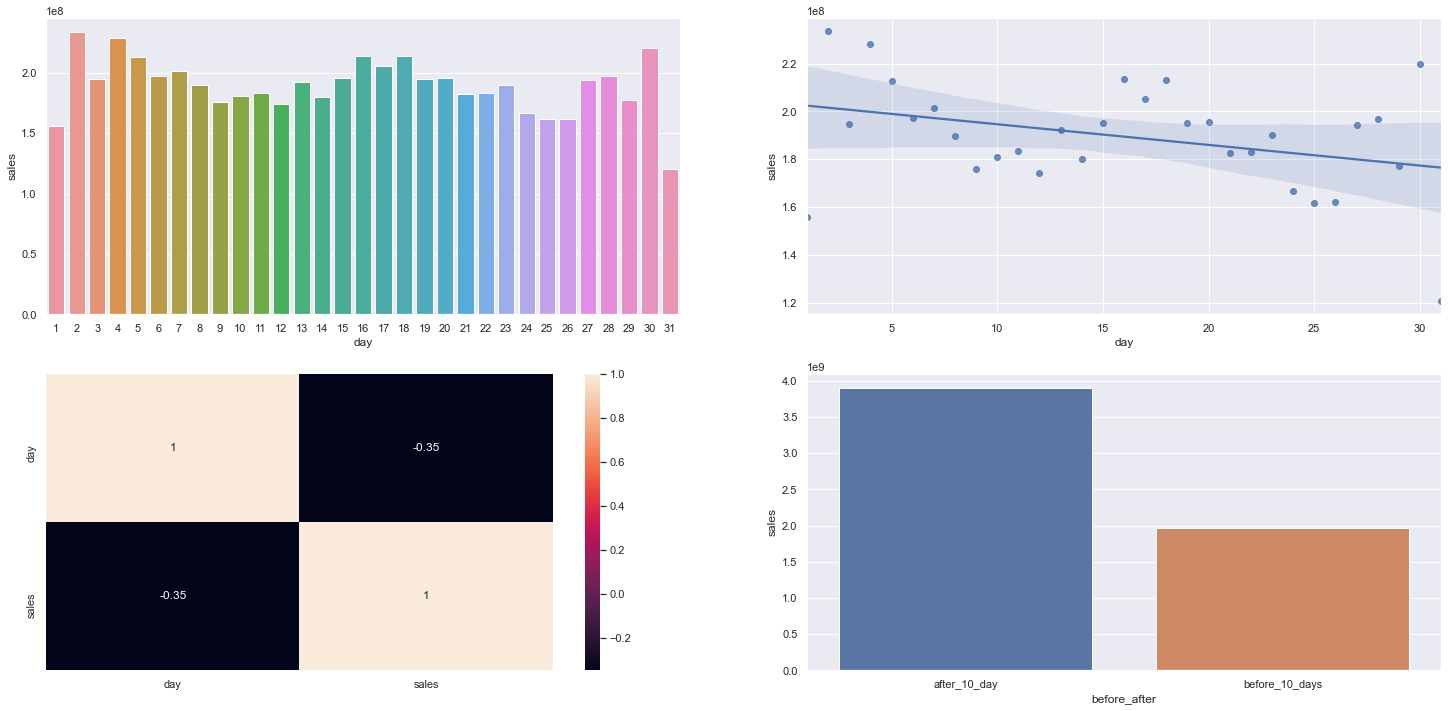

In [68]:
plt.subplot(2,2,1)
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,2)
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2)

### H11. Stores should sell less on weekends
**TRUE** Stores sell LESS on weekends 

<AxesSubplot:>

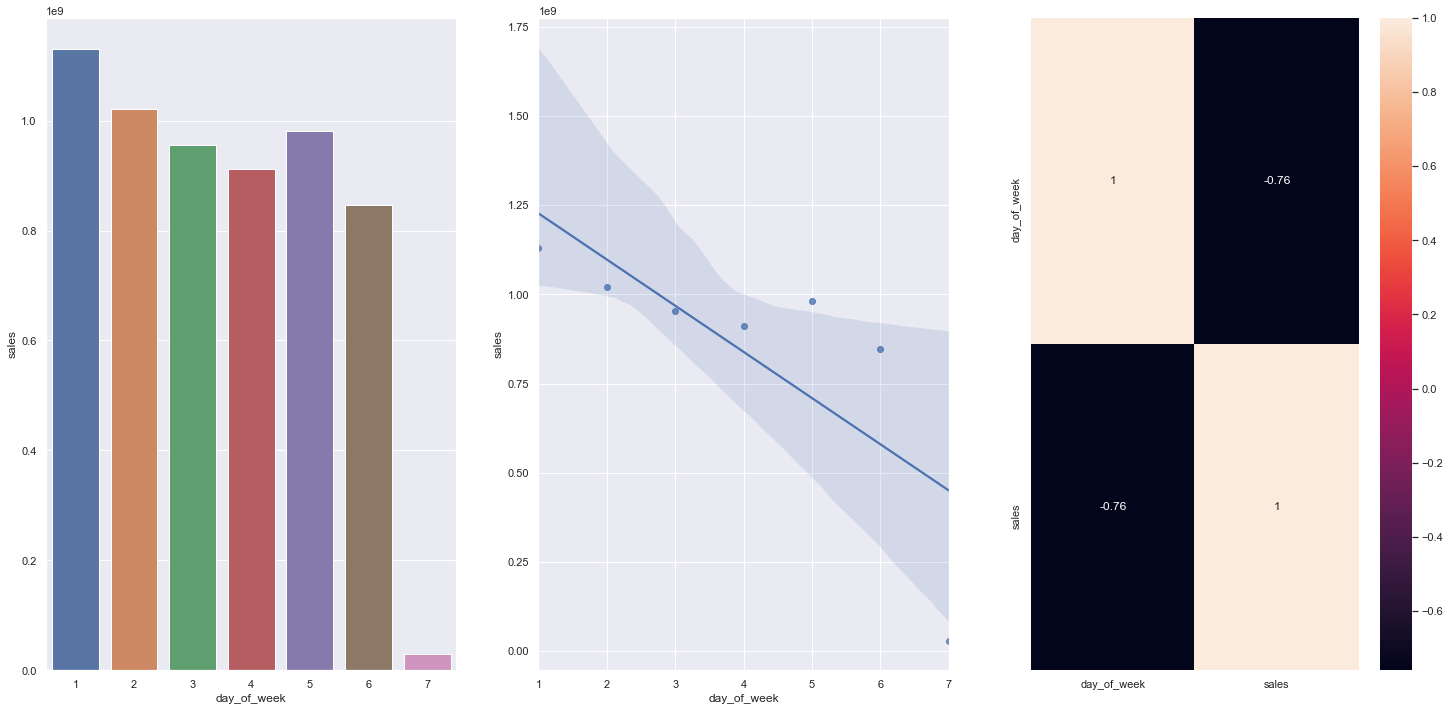

In [69]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,2)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H12. Stores should sell less during school holidays
**TRUE** Stores sell LESS during school holidays, except July and August 

<AxesSubplot:>

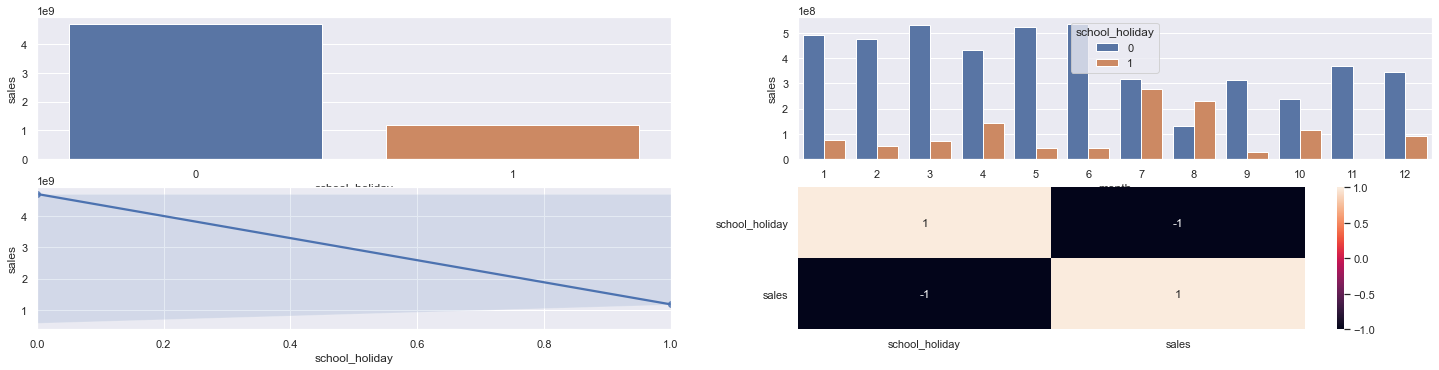

In [70]:
plt.subplot(4,2,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(4,2,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',data=aux2,hue='school_holiday')

plt.subplot(4,2,3)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.regplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(4,2,4)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### Hypotheses Resume

In [71]:
tab = [['Hipoteses','Conclusao','Relevancia'],
      ['H1','Falsa','Baixa'],
      ['H2','Falsa','Baixa'],
      ['H3','Falsa','Baixa'],
      ['H4','Falsa','Baixa'],
      ['H5','-','-'],
      ['H6','Falsa','Baixa'],
      ['H7','Falsa','Baixa'],
      ['H8','Falsa','Baixa'],
      ['H9','Falsa','Alta'],
      ['H10','Falsa','Alta'],
      ['H11','Verdadeira','Alta'],
      ['H12','Verdadeira','Alta'],
      ['H13','Verdadeira','Baixa']]
print(tabulate( tab,headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Baixa
H8           Falsa        Baixa
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 - Multivariable Analysis

### 4.3.1 - Numericals Attributes

<AxesSubplot:>

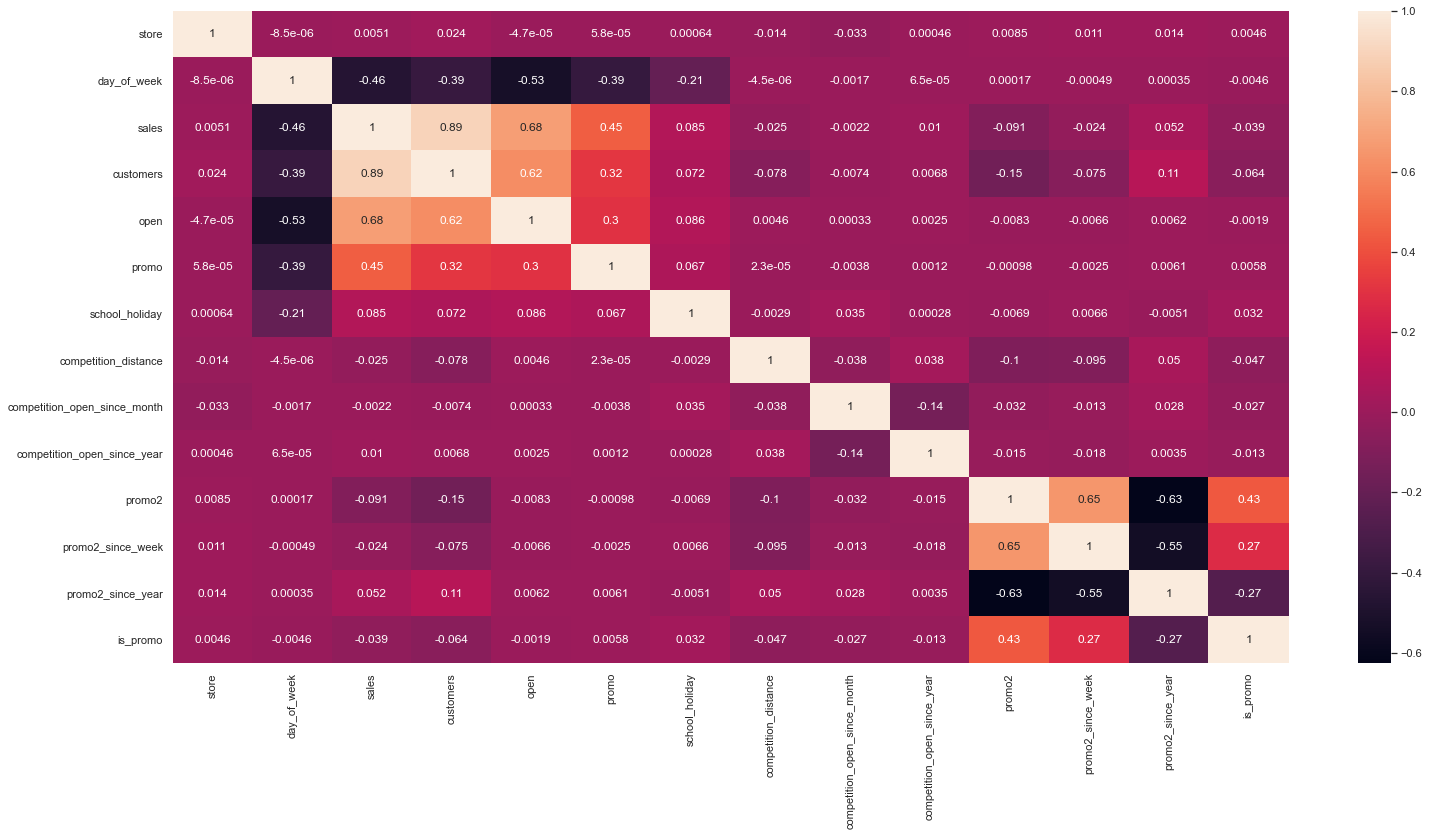

In [72]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True)

### 4.3.2 - Categorical Attributes

In [73]:
a=df4.select_dtypes(include='object')

In [74]:
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame ({'state_holiday':[a1,a2,a3],
               'store_type':[a4,a5,a6],
               'assortment':[a7,a8,a9]
              })

d = d.set_index(d.columns)

In [75]:
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

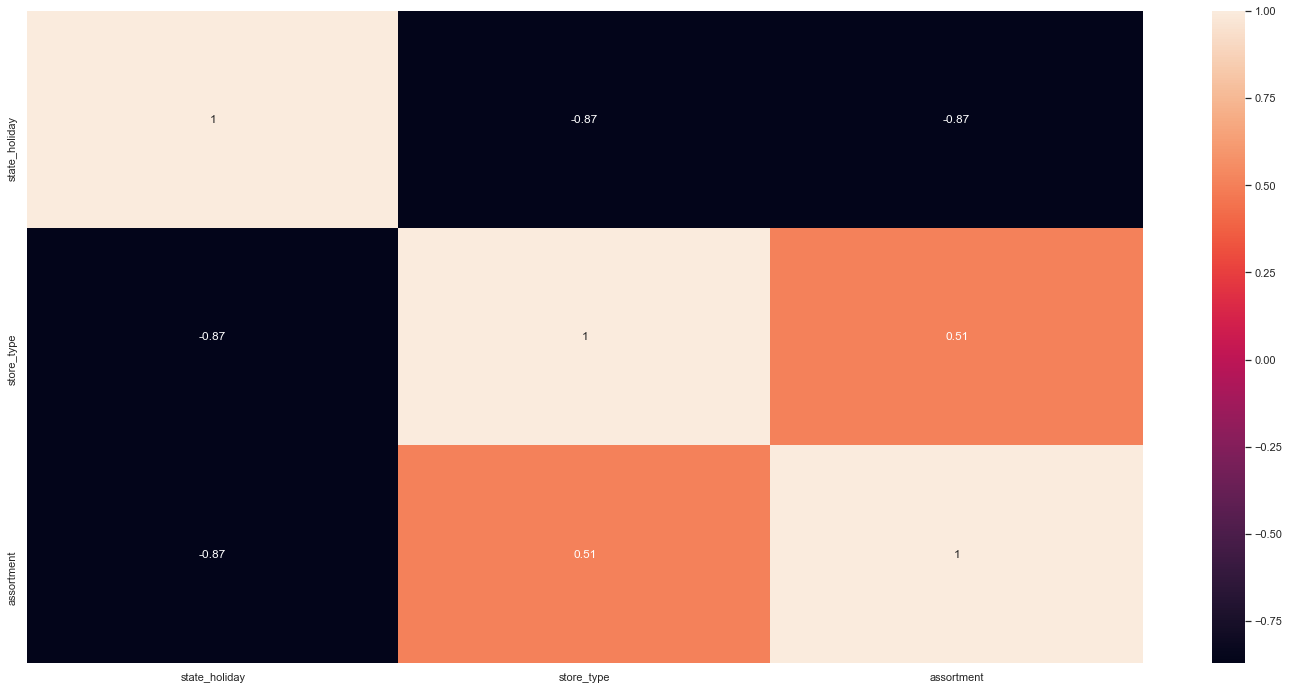

In [76]:
sns.heatmap(d.corr(method='pearson'),annot=True)

# 5.0 Preparação dos dados

In [25]:
df5 = df4.copy()

## <s>5.1 Normalização (Normalizing) </s>

## 5.2 Reescala (Reescaling)

In [26]:
a = df5.select_dtypes( include=['int64','float64'] )

In [27]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


In [28]:
rs = RobustScaler()
mms = MinMaxScaler()

<AxesSubplot:>

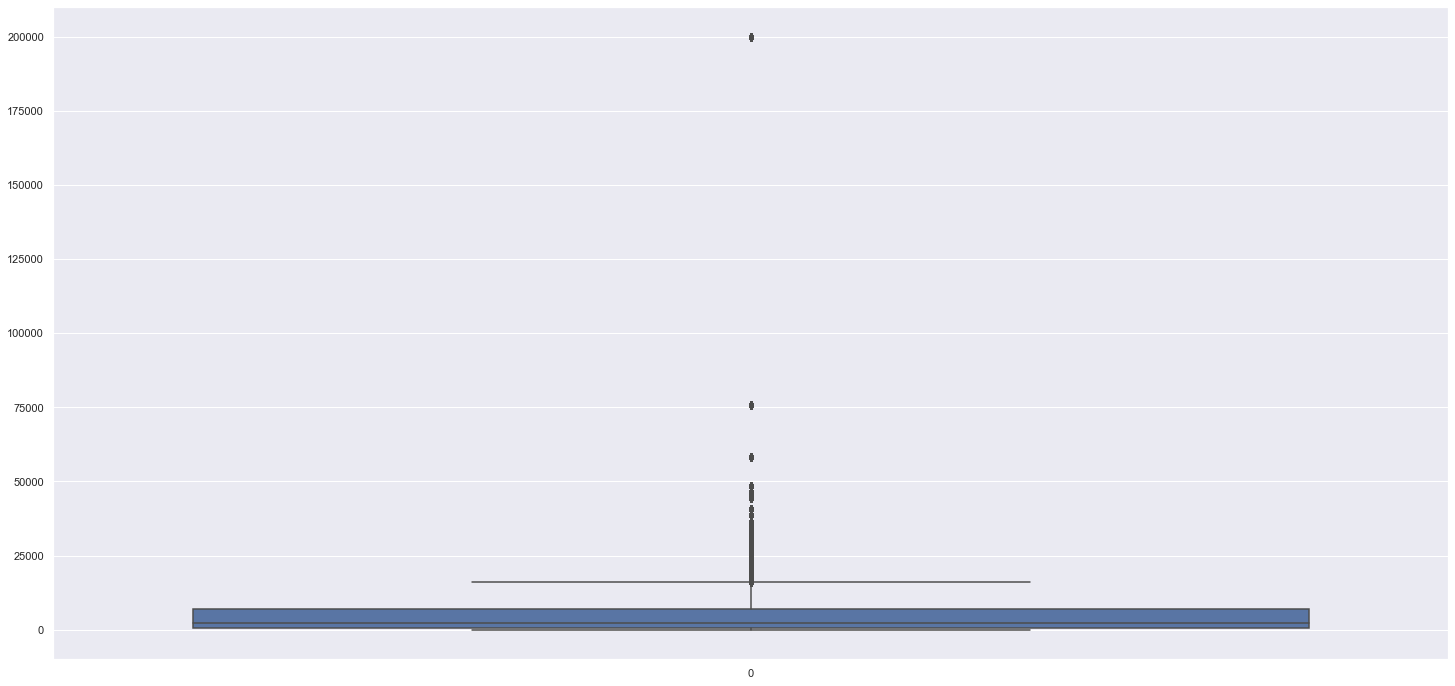

In [29]:
sns.boxplot( data=df5['competition_distance'] )

In [30]:
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open ('parametros/competition_distance_scaler.pkl','wb'))

<AxesSubplot:>

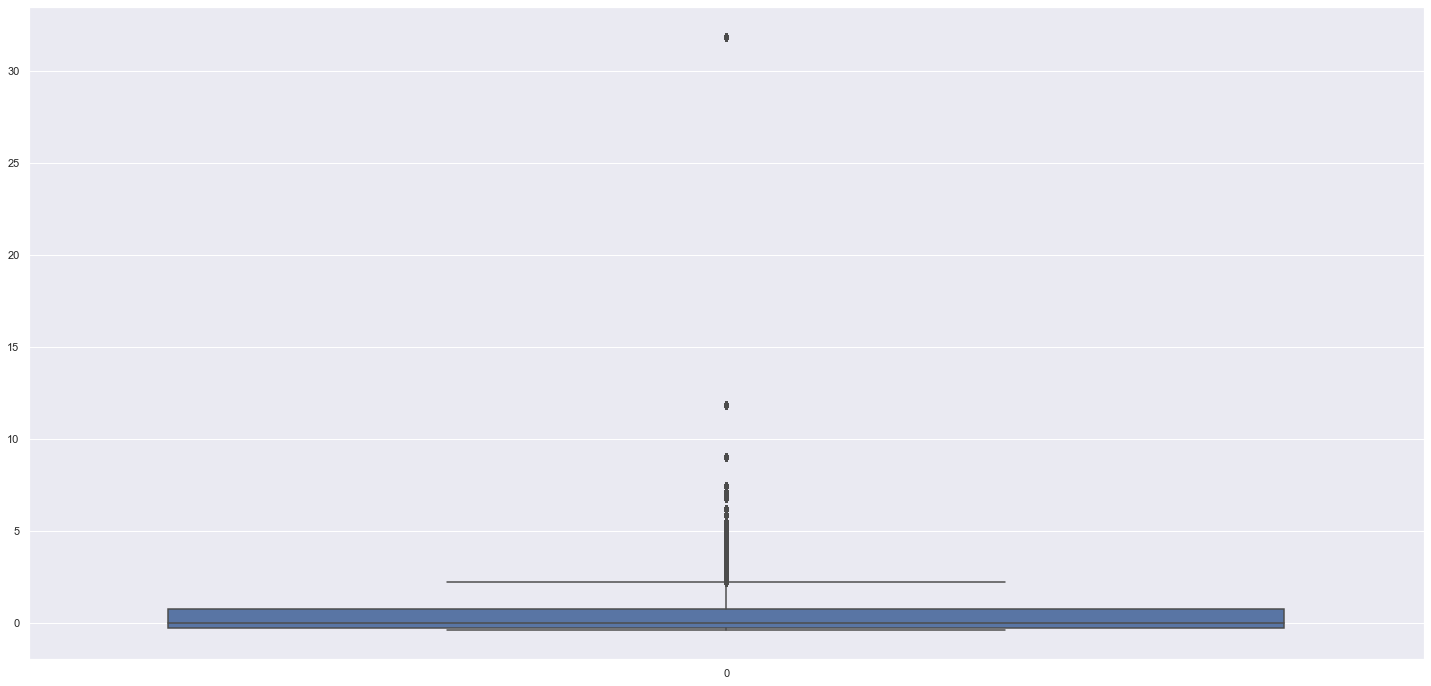

In [31]:
sns.boxplot( data=df5['competition_distance'] )

<AxesSubplot:>

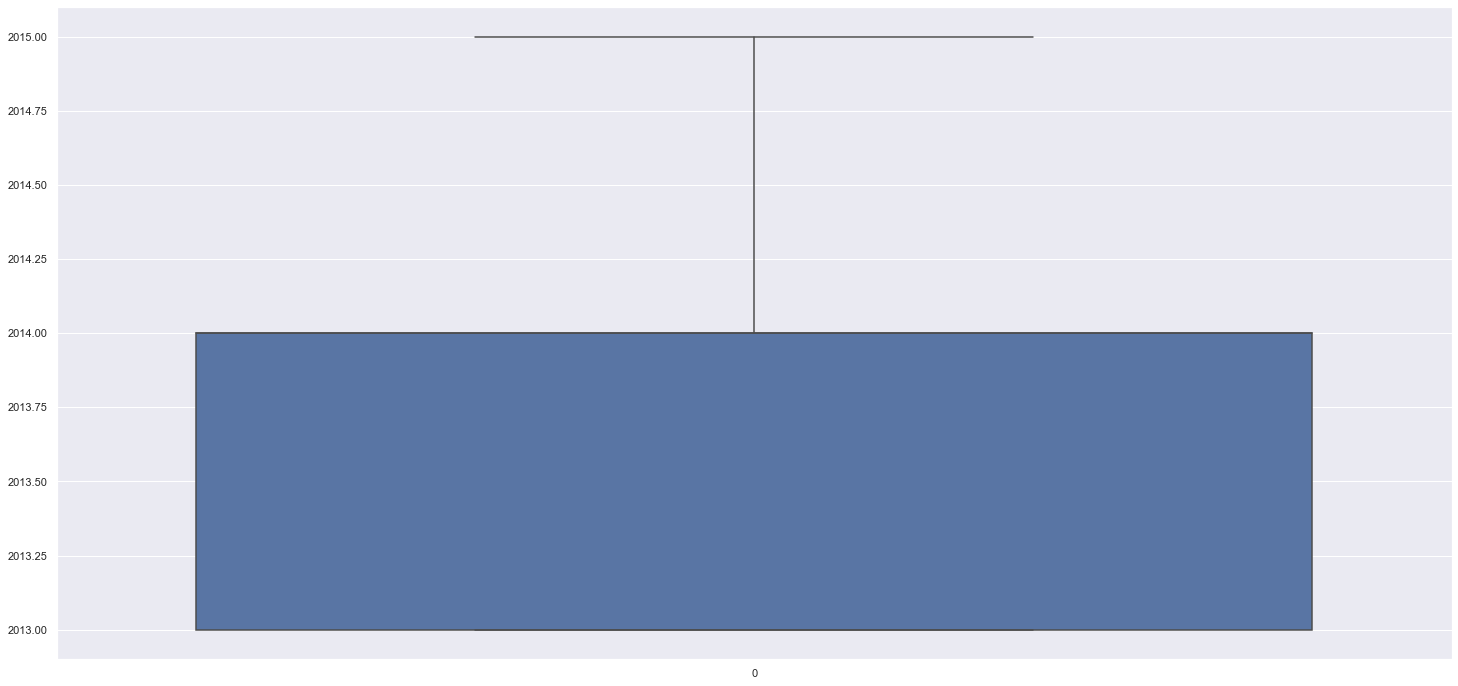

In [32]:
sns.boxplot( data=df5['year'] )

In [33]:
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open ('parametros/year_scaler.pkl','wb'))

<AxesSubplot:>

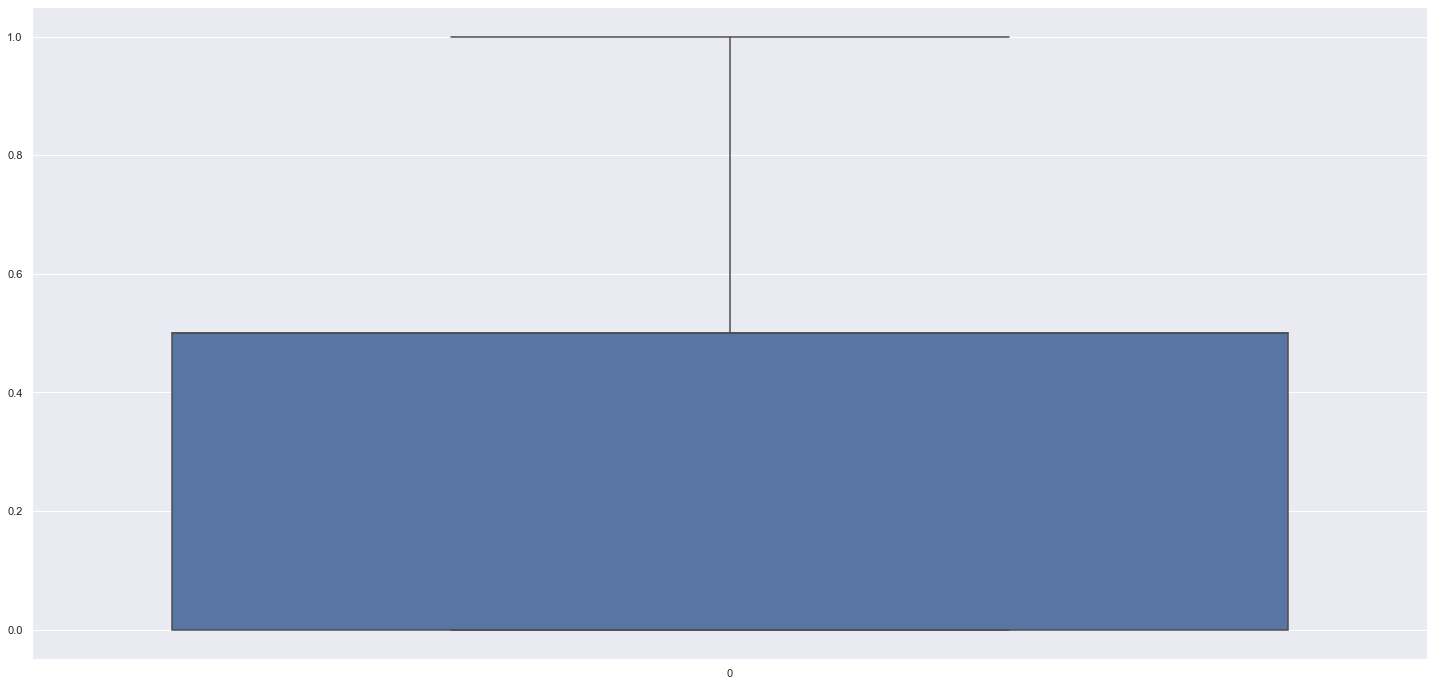

In [34]:
sns.boxplot( data=df5['year'] )

<AxesSubplot:>

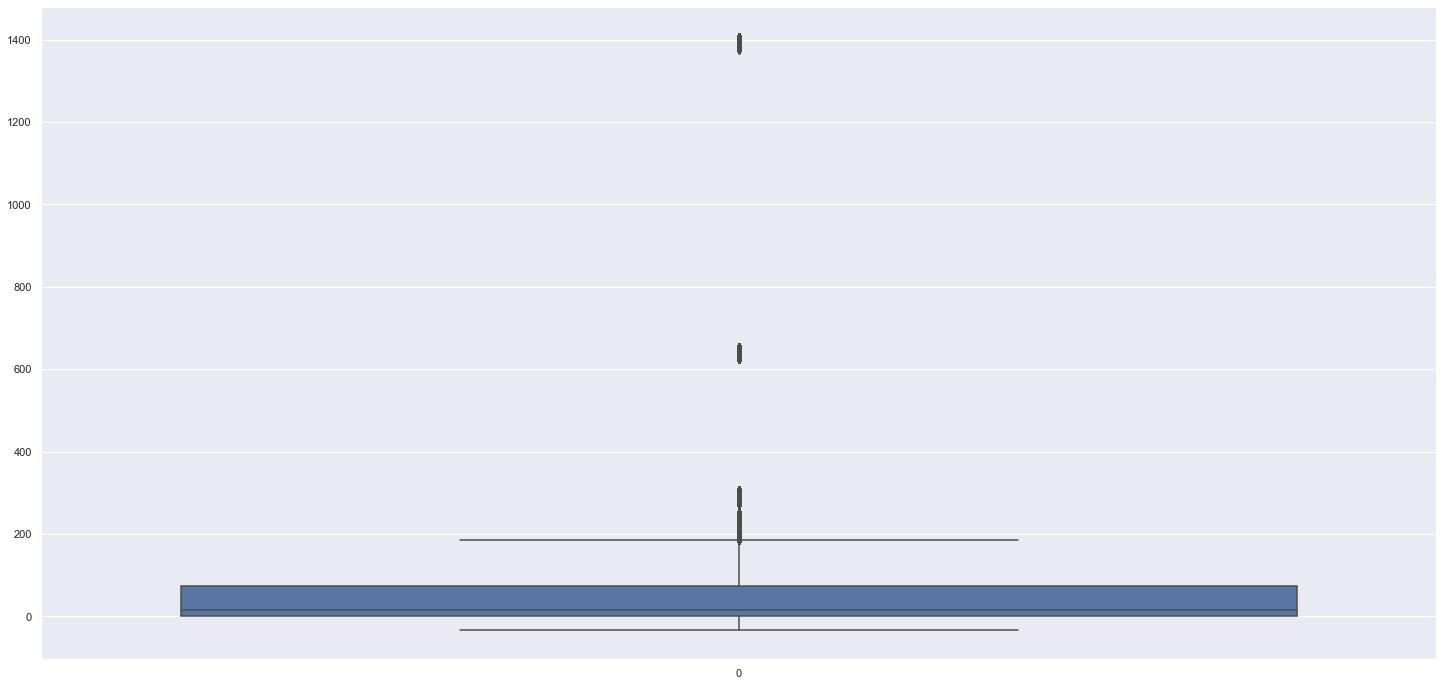

In [35]:
sns.boxplot( data=df5['competition_time_month'] )

In [36]:
df5['competition_time_month'] = rs.fit_transform (df5[['competition_time_month']].values)
pickle.dump(rs, open ('parametros/time_month_scaler.pkl','wb'))

<AxesSubplot:>

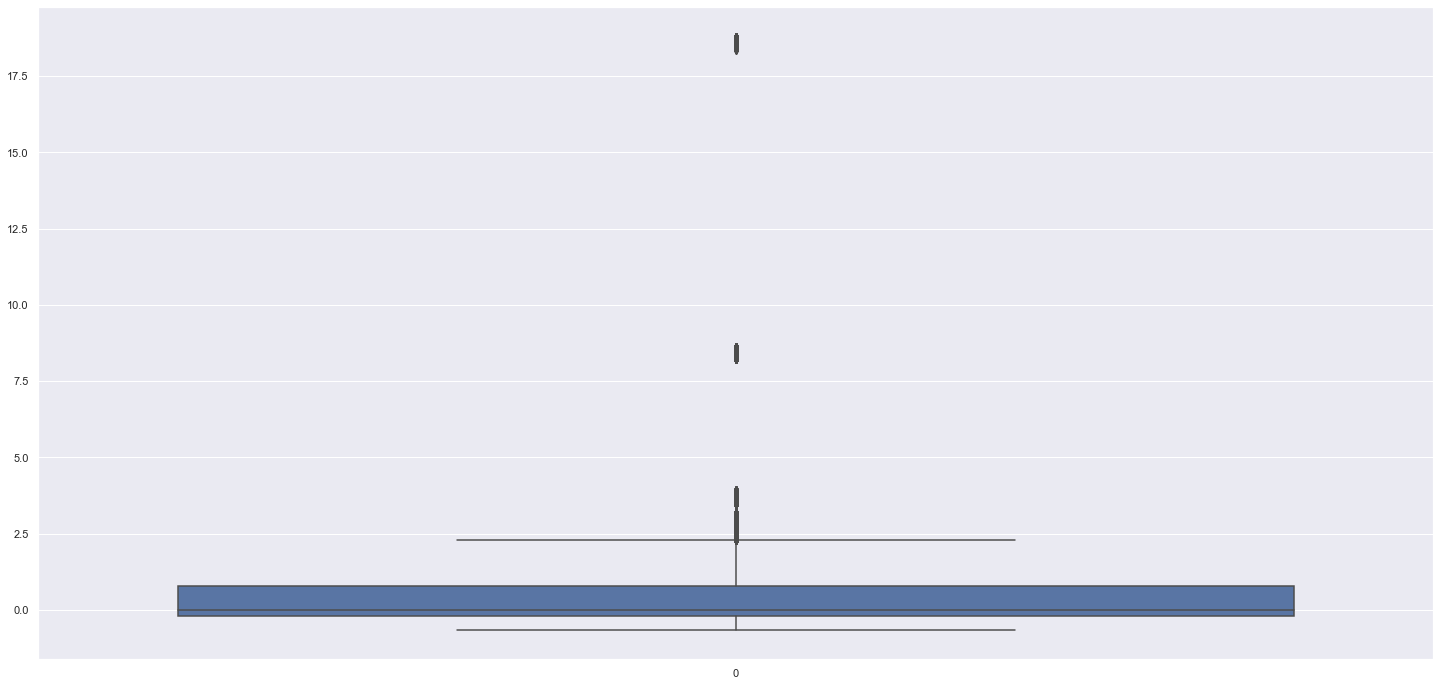

In [37]:
sns.boxplot( data=df5['competition_time_month'] )

<AxesSubplot:>

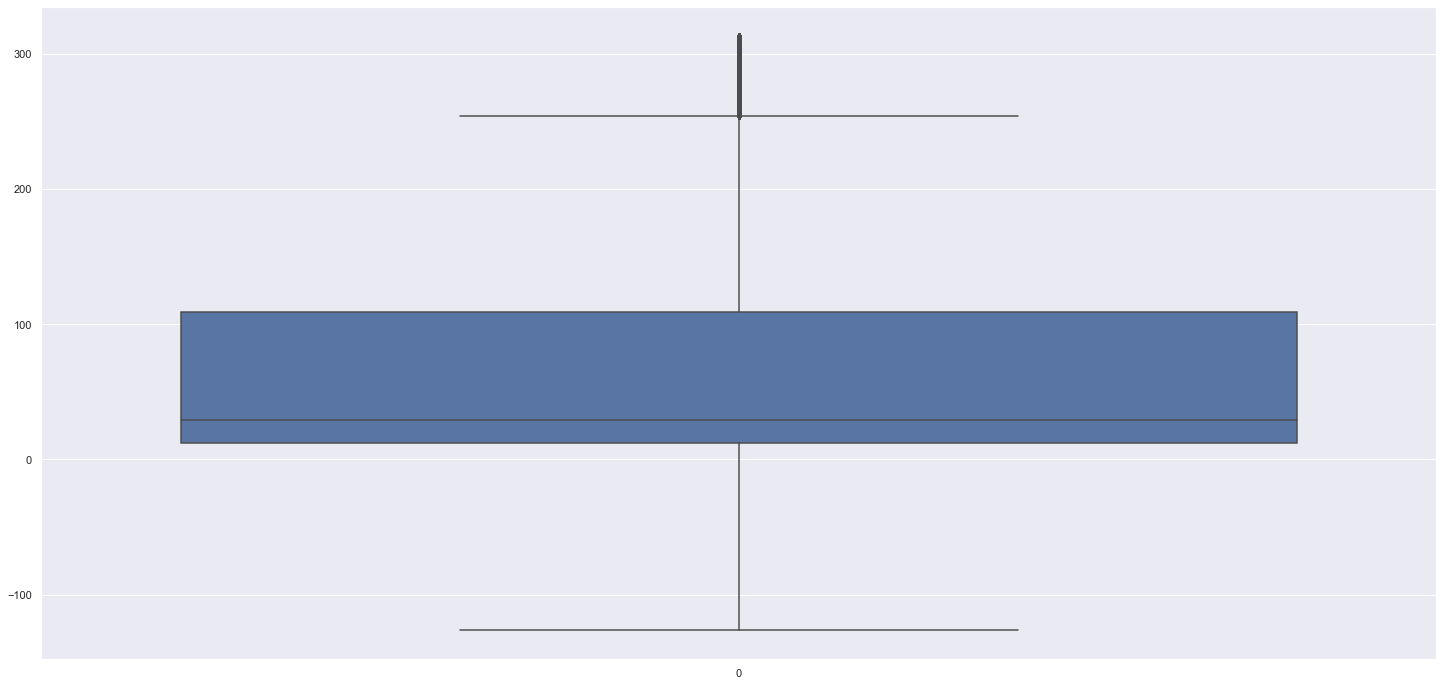

In [38]:
sns.boxplot( data=df5['promo_time_week'] )

In [39]:
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump(rs, open ('parametros/promo_time_week_scaler.pkl','wb'))

<AxesSubplot:>

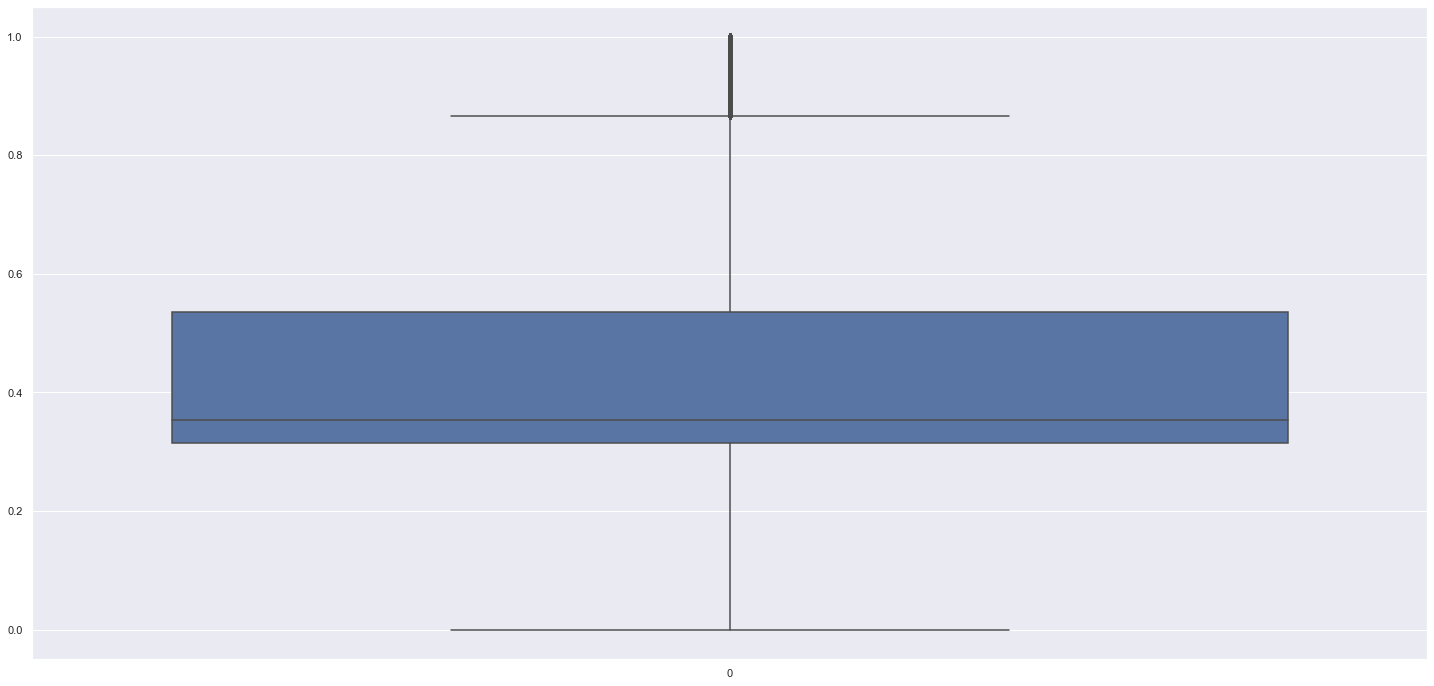

In [40]:
sns.boxplot( data=df5['promo_time_week'] )

## 5.3 Transformacao (Enconding)

### 5.3.1 Variáveis categoricas

In [41]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,7,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,7,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,7,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686


In [42]:
df5 = pd.get_dummies( df5,prefix=['state_holiday'],columns=['state_holiday'] )

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holliday,state_holiday_public_holliday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,7,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,7,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,7,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686,0,0,0,1


In [43]:
le = LabelEncoder()
df5['store_type'] = le.fit_transform ( df5['store_type'])
pickle.dump(le, open ('parametros/store_type_scaler.pkl','wb'))
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holliday,state_holiday_public_holliday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,7,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,7,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,7,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686,0,0,0,1


In [44]:
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holliday,state_holiday_public_holliday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,7,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,7,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,7,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686,0,0,0,1


### 5.3.2 Transformação da variavel resposta

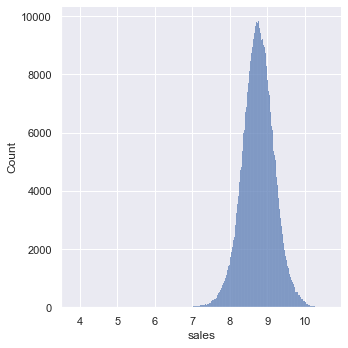

In [45]:
df5['sales']=np.log1p( df5['sales'] )
sns.displot(data=df5['sales'])

### 5.3.3 Transformação de natureza (Eventos Cíclicos)

In [96]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


In [46]:
#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin (x * ( 2.*np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos (x * ( 2.*np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin (x * ( 2.*np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos (x * ( 2.*np.pi/30 ) ) )

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin (x * ( 2.*np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos (x * ( 2.*np.pi/52 ) ) )

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin (x * ( 2.*np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos (x * ( 2.*np.pi/7 ) ) )

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holliday,state_holiday_public_holliday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,7,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,7,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,7,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Feature Selection

In [47]:
df6 = df5.copy()

## 6.1 Dividir o dataframe entre dataset de treino e teste

In [48]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holliday,state_holiday_public_holliday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,7,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,7,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,7,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


Remove columns that was derivated in feature engieneering

In [49]:
cols_drop=['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop( cols_drop, axis=1 )

Split train and test data, based on the 6 last week of sales

In [50]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [51]:
#train data
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#test data
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Data: {}'.format(x_train['date'].min()))
print('Training Max Data: {}'.format(x_train['date'].max()))
print('Testing Min Data: {}'.format(x_test['date'].min()))
print('Testning Max Data: {}'.format(x_test['date'].max()))

Training Min Data: 2013-01-01 00:00:00
Training Max Data: 2015-06-18 00:00:00
Testing Min Data: 2015-06-19 00:00:00
Testning Max Data: 2015-07-31 00:00:00


## 6.2 Seleção de Features pelo Boruta

In [97]:
x_train_n = x_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()
rf=RandomForestRegressor( n_jobs=-1)

boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Melhores features pelo Boruta

In [104]:
cols_selected = boruta.support_.tolist()

x_train_fs=x_train.drop(['date','sales'],axis=1)
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

In [106]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [107]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holliday',
 'state_holiday_public_holliday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3 Seleção de features do boruta

In [67]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

#Adding Sales , target feature, and datethat was not enconding
feat_to_add =['date','sales']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 Modelos de Machine Learning

In [59]:
df7=df6.copy()

**Supervisionado** - Reconhecimento das features é baseado nos dados em que o algoritimo foi ensinado passando exemplos e a resposta esperada. Para variaveis respostas são categóricas, usa-se modelos de classificação. quando a variável resposta é numérica, usa-ve modelos de regressão. Exite também modelos de Séries temporais que geram previsão futuras.

**Não-Supervisionado** - O algoritimo aprende baseado nas similaridade entre as features, fazendo uma clusterização.

**Semi-supervisionado** - Reinforcement Learning trabalha com as entidades Agente e Ambiente. Agente faz inumeras ações ao ambiente e o ambiente respode com uma recompensa positiva ou negativa.

## 7.1 Modelos Lineares

In [60]:
x_train_b=x_train[cols_selected_boruta]
x_test_b=x_test[cols_selected_boruta]

### 7.1.1 Modelo de Média (Average Model)

In [61]:
aux1=x_test_b.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns= {'sales':'predictions'})
aux1=pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

baseline_result = ml_error( 'Average Model', np.expm1(y_test),np.expm1(yhat_baseline) )
baseline_result 

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.1.2 Modelo de regressão linear (Linear Regression)

In [62]:
lr = LinearRegression().fit(x_train_b,y_train)

yhat_lr = lr.predict(x_test_b)

lr_result = ml_error( 'Linear Regression', np.expm1(y_test),np.expm1(yhat_lr) )
lr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.999225,0.294903,2665.742106


### 7.1.3 Modelo de regressão Regularizada (Linear Regression Regularized) - Lasso

In [63]:
lrr = Lasso( alpha = 0.01).fit(x_train_b,y_train)
yhat_lrr = lrr.predict(x_test_b)
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test),np.expm1(yhat_lrr) )
lrr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1894.725095,0.288322,2756.092763


## 7.2 Modelos Não Lineares

### 7.2.1 Modelo de regressão de floresta aleatória (Random Forest Regressor)

In [64]:
rf = RandomForestRegressor( n_estimators=100,n_jobs=-1,random_state=42).fit(x_train_b,y_train)

yhat_rf = rf.predict(x_test_b)

rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf) )
rf_result 

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,666.72962,0.098087,995.510447


### 7.2.2 Modelo de regressão de XGBoost (XGBoost Regressor)

In [65]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train_b,y_train)

yhat_xgb = model_xgb.predict(x_test_b)


xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test),np.expm1(yhat_xgb) )
xgb_result 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.430935,0.94946,7330.600012


## 7.3 Comparar as performance dos modelos

In [66]:
modelling_results = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,666.729620,0.098087,995.510447
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1868.999225,0.294903,2665.742106
0,Linear Regression - Lasso,1894.725095,0.288322,2756.092763
0,XGBoost Regressor,6683.430935,0.949460,7330.600012


## 7.4 Time Series Cross-Validation

In [68]:
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend( feat_to_add)
x_training = x_train[cols_selected_boruta_full]

In [69]:
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,6,2015,0.891892,0.330296,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,6,2015,0.729730,0.330296,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,6,2015,-0.189189,0.330296,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.502080


In [70]:
lr_result_cv=cross_validation(x_training,5,'Linear Regression',lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.24+/-301.77,0.3+/-0.02,2963.5+/-486.08


In [71]:
lasso_result_cv=cross_validation(x_training,5,'Lasso',lrr)
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2122.84+/-364.56,0.29+/-0.01,3059.41+/-543.84


In [72]:
rf_result_cv=cross_validation(x_training,5,'Random Forest',rf,True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,841.99+/-236.18,0.12+/-0.03,1260.26+/-349.24


In [73]:
xgb_result_cv=cross_validation(x_training,5,'XGB Boost',model_xgb,True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Boost,7049.21+/-588.77,0.95+/-0.0,7715.07+/-689.77


In [74]:
modelling_result_cv= pd.concat([lr_result_cv,lasso_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,841.99+/-236.18,0.12+/-0.03,1260.26+/-349.24
0,Linear Regression,2094.24+/-301.77,0.3+/-0.02,2963.5+/-486.08
0,Lasso,2122.84+/-364.56,0.29+/-0.01,3059.41+/-543.84
0,XGB Boost,7049.21+/-588.77,0.95+/-0.0,7715.07+/-689.77


# 8.0 Tunning de Hyper Parameter

## 8.1 Random Search

In [75]:
param = {'n_estimators': [1500,1700,2500,3000,3500],
         'eta': [0.01,0.03],
         'max_depth': [3,5,9],
         'subsample': [0.1,0.5,0.7],
         'colsample_bytree': [0.3,0.7,0.9],
         'min_child_weight': [3,8,15]}
MAX_EVAL=5

In [76]:
rs_result = pd.DataFrame()
for i in range (MAX_EVAL):
    hp = {k: rds.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])

    
    xgb_result_rs=cross_validation(x_training,5,'XGB Boost',model_xgb,True)
    rs_result=pd.concat([rs_result,xgb_result_rs])
rs_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Boost,1072.48+/-150.43,0.15+/-0.02,1543.37+/-196.33
0,XGB Boost,1564.5+/-169.81,0.22+/-0.01,2252.2+/-227.98
0,XGB Boost,1235.65+/-141.69,0.17+/-0.01,1782.04+/-178.98
0,XGB Boost,1592.16+/-171.64,0.22+/-0.01,2296.9+/-226.09
0,XGB Boost,1159.79+/-120.75,0.16+/-0.01,1670.56+/-159.17


## 8.2 Final Model

In [77]:
param_tuned = {'n_estimators':1500 ,
               'eta': 0.3,
               'max_depth': 9,
               'subsample':0.5 ,
               'colsample_bytree':0.7,
               'min_child_weight': 15}

In [78]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train_b,y_train)

yhat_xgb_tuned=model_xgb_tuned.predict(x_test_b)

xgb_result_tunes=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tunes

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,757.064052,0.108703,1079.175245


In [80]:
mpe  = mean_percentage_error( np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.018616555055402953

In [ ]:
pickle.dump( model_xgb_tuned, open ( 'modelo/model_rossman.pkl' ,'wb') )

# 9.0  Tradução e Interpretação do erro

In [89]:
df9 = x_test[cols_selected_boruta_full]

#backing original data
df9['sales'] = np.expm1 (df9['sales'])
df9['predictions'] = np.expm1 (yhat_xgb_tuned)

## 9.1 Perfomance do Negocio

In [90]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'],x['predictions'])).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'],x['predictions'])).reset_index().rename( columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on='store')

df92 = pd.merge(df91,df9_aux3,how='inner',on='store')

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92=df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [91]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
350,351,232989.953125,232376.081715,233603.824535,613.871410,0.107010
738,739,363219.406250,362173.128167,364265.684333,1046.278083,0.097137
880,881,146268.937500,145746.604466,146791.270534,522.333034,0.125736
312,313,240490.500000,239755.598468,241225.401532,734.901532,0.100625


In [92]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,259345.140625,252145.015859,266545.265391,7200.124766,0.501892
291,292,103036.132812,99911.598787,106160.666838,3124.534025,0.495328
549,550,260730.531250,258878.306509,262582.755991,1852.224741,0.368233
875,876,193630.546875,189459.471000,197801.622750,4171.075875,0.317774
594,595,404547.625000,400907.786093,408187.463907,3639.838907,0.248596


<AxesSubplot:xlabel='store', ylabel='MAPE'>

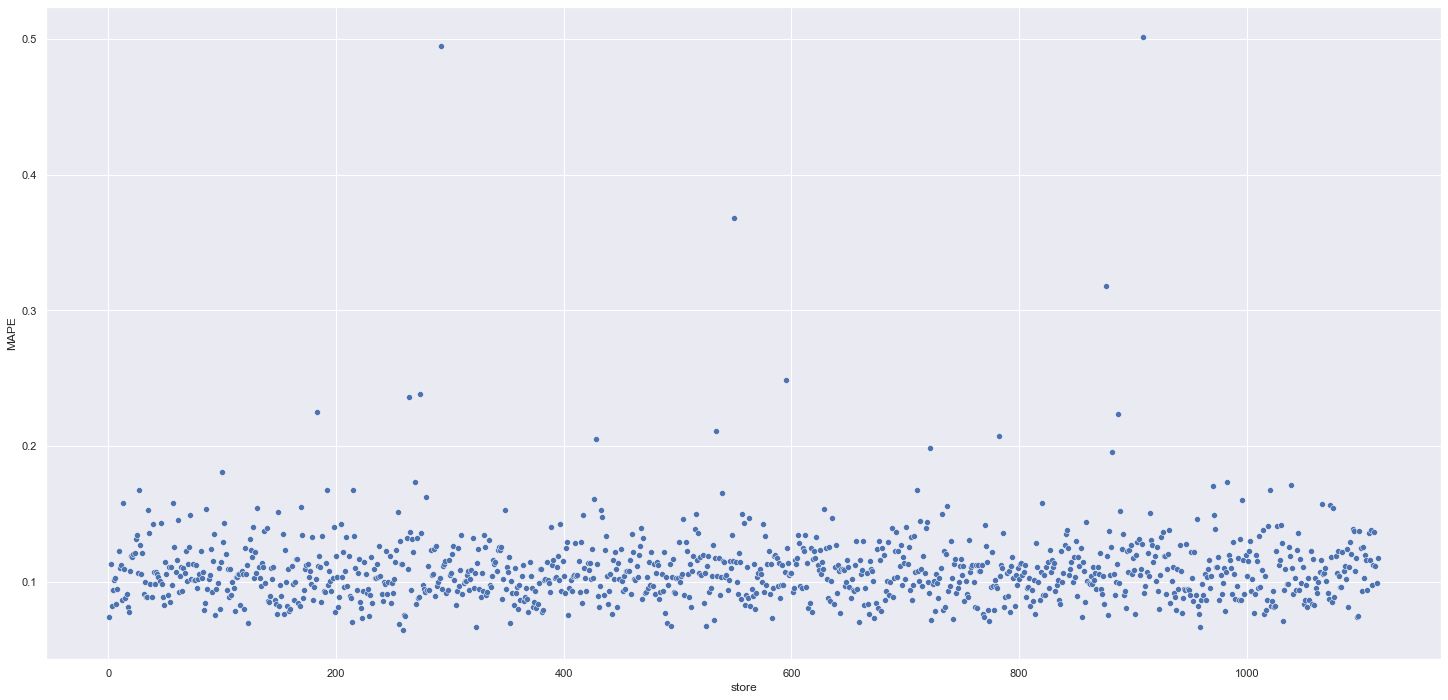

In [93]:
sns.scatterplot(x='store',y='MAPE',data=df92)

## 9.2 Perfomance Geral

In [94]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename( columns = {'index':'Scenario', 0 :'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$280,433,856.00"
1,worst_scenario,"R$279,585,921.17"
2,best_scenario,"R$281,281,825.06"


## 9.3 Perfomance do ML

In [95]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['sales'] / df9['predictions']

<AxesSubplot:xlabel='predictions', ylabel='error'>

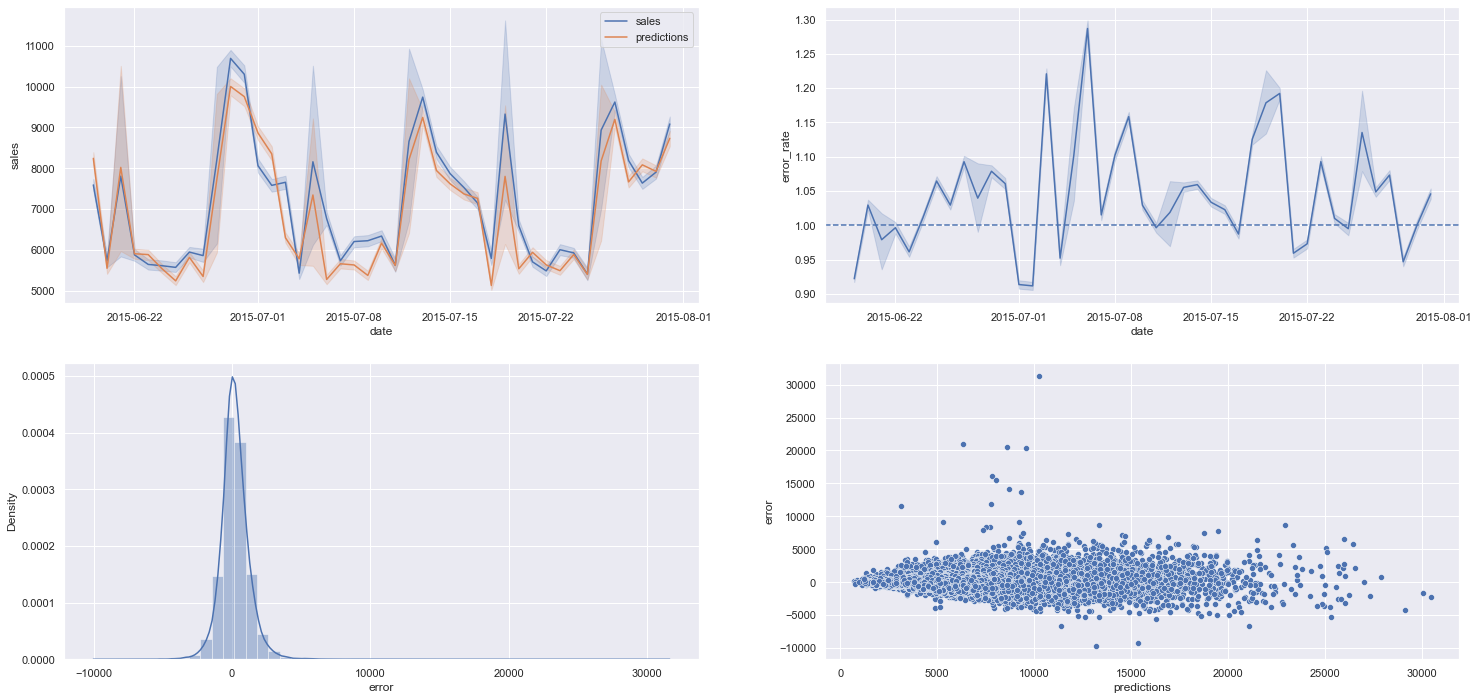

In [96]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='sales')
sns.lineplot(x='date',y='predictions',data=df9,label='predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x=df9['predictions'],y=df9['error'])

# 10.0 Deploy do Modelo em Produção

## 10.1 Rossman Class

In [4]:
import pickle
import inflection
import pandas as pd
import math
import numpy as np
import math
import datetime

class Rossman ( object ):
    def __init__(self):
        self.home_path='C:/repositorioGit/DSemProducao/kaggleRossman/'
        self.competition_distance_scaler = pickle.load(open (self.home_path + 'parametros/competition_distance_scaler.pkl','rb'))
        self.time_month_scaler = pickle.load(open (self.home_path + 'parametros/time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler = pickle.load(open (self.home_path + 'parametros/promo_time_week_scaler.pkl','rb'))
        self.year_scaler= pickle.load(open (self.home_path + 'parametros/year_scaler.pkl','rb'))
        self.store_type_scaler = pickle.load(open (self.home_path + 'parametros/store_type_scaler.pkl','rb'))
    def data_cleaning(self,df1):


        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment',       'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase,cols_old))

        df1.columns = cols_new

        df1['date']=pd.to_datetime(df1['date'])

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
        df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Set',10: 'Oct',11: 'Nov',12: 'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map']=df1['date'].dt.month.map(month_map)

        df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    def feature_engineering(self,df2):
        df2['year']=df2['date'].dt.year

        df2['month']=df2['date'].dt.month

        df2['day']=df2['date'].dt.day

        df2['week_of_year']=df2['date'].dt.weekofyear

        df2['year_week']=df2['date'].dt.strftime( '%Y-%W' )

        df2['competition_since'] = df2.apply( lambda x: datetime.datetime ( year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days ).astype (int)

        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' +df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime ( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype ( int )

        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holliday' if x =='a' else 'easter_holliday' if x=='b' else 'christmas' if x=='c' else 'regular_day')
        
        df2 = df2[ ( df2['open'] !=0 ) ]
        
        cols_drop=['open', 'promo_interval' , 'month_map']
        df2 = df2.drop(cols_drop,axis=1)
        
        return df2
    
    def data_preparation (self,df5):
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        df5['competition_time_month'] = self.time_month_scaler.fit_transform (df5[['competition_time_month']].values)
        
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
        
        df5 = pd.get_dummies( df5,prefix=['state_holiday'],columns=['state_holiday'] )

        df5['store_type'] = self.store_type_scaler.fit_transform ( df5['store_type'])
        
        assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin (x * ( 2.*np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos (x * ( 2.*np.pi/12 ) ) )

        df5['day_sin'] = df5['day'].apply( lambda x: np.sin (x * ( 2.*np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos (x * ( 2.*np.pi/30 ) ) )

        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin (x * ( 2.*np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos (x * ( 2.*np.pi/52 ) ) )

        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin (x * ( 2.*np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos (x * ( 2.*np.pi/7 ) ) )
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self,model,original_data,test_data):
        pred = model.predict(test_data)
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [5]:
import pickle
import pandas as pd
from flask import Flask,request,Response
from api.rossman.Rossman import Rossman

model = pickle.load(open('C:/repositorioGit/DSemProducao/kaggleRossman/modelo/model_rossman.pkl','rb'))

app = Flask(__name__)
@app.route('/rossman/predict',methods=['POST'])

def rossman_predict():
    test_json= request.get_json()
    
    if test_json:
        if isinstance(test_json,dict):#Se tem apenas uma json
            test_raw=pd.DataFrame(test_json,index=[0])
        else:#se sai varios json concatenados
            test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
            
        pipeline = Rossman()
        df1 = pipeline.data_cleaning( test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)
        df_response = pipeline.get_prediction(model,test_raw,df3)

        return df_response
    
    else:
        return Response('{}', status=200,mimetype='application/json')

    
if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


## 10.3 API Tester

In [7]:
import json
import requests
df_store_raw = pd.read_csv ('data/store.csv', low_memory=False)

In [8]:
df10=pd.read_csv('data/test.csv')
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
df_test=pd.merge(df10,df_store_raw,how='left',on='Store')

df_test=df_test[df_test['Store']==22]

df_test=df_test[df_test['Open']!=0]

df_test=df_test[~df_test['Open'].isnull()]

df_test=df_test.drop('Id',axis=1)


In [10]:
data = json.dumps(df_test.to_dict(orient='records'))

In [13]:
url='https://rossman-model-201212.herokuapp.com/rossman/predict'
header={'Content-type':'application/json'}
data = data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [15]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [17]:
d2= d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print ('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i,'store'],
    d2.loc[i,'prediction']))

Store Number 22 will sell R$162,986.27 in the next 6 weeks
